In [1]:
import os

import itertools

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import tensorflow as tf

from scipy.fft import fft, dct
import scipy.stats as stats

import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('max_columns', None)

In [4]:
DATA_PATH = '../../Data/TRANSFORMED_DATA/lr_transformed_cea_data.csv'

In [5]:
class fixedFrameConstructor:
    """
    A class to generate frames of data based on fixed window size.

    ...

    Attributes
    ----------
    df : dataframe
       the dataframe that contains all of the data
    frame_size : int
       the size of each sliced window
    skip_size : int
       the size of the window that should skipped before creating a new one
    Methods
    -------
    df_to_fixed_frames
       Creates a tuple of the frames containing the sequence of temporal series and the corresponding 
       labels. Each frame is reduced to a vactor thanks to a PCA algorithm
    df_to_fixed_dct_frames
       Creates a tuple of the frames containing the DCT transform of the sequence of temporal series 
       and the corresponding labels. Each frame is reduced to a vactor thanks to a PCA algorithm
    df_to_fixed_fft_frames
       Creates a tuple of the frames containing the FFT transform of the sequence of temporal series 
       and the corresponding labels. Each frame is reduced to a vactor thanks to a PCA algorithm
    """
    def __init__(self, df):
        """
        Initialize the dataframe

        ...

        Parameters
        ----------
        df : dataframe
           the dataframe that contains all of the data
        """
        self.df = df
        
    def df_to_fixed_frames(self, frame_size, skip_size):
        """Creates a tuple of the frames containing the sequence of temporal series and the corresponding 
        labels. Each frame is reduced to a vactor thanks to a PCA algorithm
        
        Parameters
        ----------
        frame_size : int
           the size of each sliced window
        skip_size : int
           the size of the window that should skipped before creating a new one
       
        Returns
        -------
        frames : array
            An array containing sub-arrays of each reduced frame of data
        labels : array
            An array containing labels corresponding to each sub-frame
        """
        n_components = min(frame_size, 6)
        frames = []
        labels = []
        for i in range(0, len(self.df) - frame_size, skip_size):
            acc_x = self.df['Acc_x'].values[i:i+frame_size]
            acc_y = self.df['Acc_y'].values[i:i+frame_size]
            acc_z = self.df['Acc_z'].values[i:i+frame_size]

            gyro_x = self.df['Gyro_x'].values[i:i+frame_size]
            gyro_y = self.df['Gyro_y'].values[i:i+frame_size]
            gyro_z = self.df['Gyro_z'].values[i:i+frame_size]

            label = stats.mode(self.df['appui_leve'][i:i+frame_size])[0][0]

            temp_frame = np.asarray([acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z])
            
            frames.append(temp_frame)
            labels.append(label)

        frames = np.asarray(frames)#.reshape(-1, 6 * n_components)
        labels = np.asarray(labels)

        return frames, labels
    
    def df_to_fixed_dct_frames(self, frame_size, skip_size):
        """Creates a tuple of the frames containing the DCT transform of the sequence of temporal series 
        and the corresponding labels. Each frame is reduced to a vactor thanks to a PCA algorithm
        
        Parameters
        ----------
        frame_size : int
           the size of each sliced window
        skip_size : int
           the size of the window that should skipped before creating a new one
       
        Returns
        -------
        frames : array
            An array containing sub-arrays of each reduced frame of data
        labels : array
            An array containing labels corresponding to each sub-frame
        """
        n_components = min(frame_size, 6)
        frames = []
        labels = []
        for i in range(0, len(self.df) - frame_size, skip_size):
            acc_x = dct(self.df['Acc_x'].values[i:i+frame_size])
            acc_y = dct(self.df['Acc_y'].values[i:i+frame_size])
            acc_z = dct(self.df['Acc_z'].values[i:i+frame_size])

            gyro_x = dct(self.df['Gyro_x'].values[i:i+frame_size])
            gyro_y = dct(self.df['Gyro_y'].values[i:i+frame_size])
            gyro_z = dct(self.df['Gyro_z'].values[i:i+frame_size])

            label = stats.mode(self.df['appui_leve'][i:i+frame_size])[0][0]

            temp_frame = np.asarray([acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z])
            
            frames.append(temp_frame)
            labels.append(label)

        frames = np.asarray(frames)#.reshape(-1, 6 * n_components)
        labels = np.asarray(labels)

        return frames, labels
    
    def df_to_fixed_fft_frames(self, frame_size, skip_size):
        """Creates a tuple of the frames containing the FFT transform of the sequence of temporal series 
        and the corresponding labels. Each frame is reduced to a vactor thanks to a PCA algorithm
        
        Parameters
        ----------
        frame_size : int
           the size of each sliced window
        skip_size : int
           the size of the window that should skipped before creating a new one
       
        Returns
        -------
        frames : array
            An array containing sub-arrays of each reduced frame of data
        labels : array
            An array containing labels corresponding to each sub-frame
        """
        n_components = min(frame_size, 6)
        frames = []
        labels = []
        for i in range(0, len(self.df) - frame_size, skip_size):
            acc_x = fft(self.df['Acc_x'].values[i:i+frame_size]).real
            acc_y = fft(self.df['Acc_y'].values[i:i+frame_size]).real
            acc_z = fft(self.df['Acc_z'].values[i:i+frame_size]).real

            gyro_x = fft(self.df['Gyro_x'].values[i:i+frame_size]).real
            gyro_y = fft(self.df['Gyro_y'].values[i:i+frame_size]).real
            gyro_z = fft(self.df['Gyro_z'].values[i:i+frame_size]).real

            label = stats.mode(self.df['appui_leve'][i:i+frame_size])[0][0]

            temp_frame = np.asarray([acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z])
            
            frames.append(temp_frame)
            labels.append(label)

        frames = np.asarray(frames)#.reshape(-1, 6 * n_components)
        labels = np.asarray(labels)

        return frames, labels

In [14]:
class FormatData:
    """
    A class to generate a dictionnary containing training and test data as well as frames and 
    dataframes that are sessential to recreate the original signal.

    ...

    Attributes
    ----------
    data_path : str
       the path to the csv file
    id_out : str
       the ID of the patient to use for test data
    train_df : dataframe
       the data frame created from the list patient IDs used fot the training set
    test_df : dataframe
       the data frame created from the patient ID used fot the test set
    train_var_frames : list
       the list of frames created from the training data
    test_var_frames : list
       the list of frames created from the test data
    transform : str
       the name of transform to use for data (None, dct or fft)
    window_size : int
       the size of each sliced window
    skip_size : int
       the size of the window that should skipped before creating a new one
    window_type : str
       the type of window to use, fixed or vary
    
    Methods
    -------
    loso_split
       Splits data into training and test data by Leaving One Subject One
    variate_window_df
       Creates a list of frames based on the target variable, each time
       the value of the target is swithing a new frame is created
    create_variate_frames
       Creates data matrices as well as the targets for both training and testing
    create_fixed_frames
       Creates data matrices as well as the targets for both training and testing
    """
    def __init__(self, data_path):
        """
        Initialize path to the data file, reads the file and initializes the data matrices

        ...

        Parameters
        ----------
        data_path : str
            The path leading to the data file
        """
        self.data_path = data_path
        self.data = pd.read_csv(self.data_path)
        
        self.X_train = []
        self.X_test = []
        self.y_train = []
        self.y_test = []
        
    def loso_split(self, id_out='P42'):
        """Splits data into training and test data by Leaving One Subject One

        Parameters
        ----------
        id_out : str
            the ID of the patient to use for test data

        Returns
        -------
        train_df : dataframe
           the data frame created from the list patient IDs used fot the training set
        test_df : dataframe
           the data frame created from the patient ID used fot the test set
        """
        train_df = self.data[self.data.id_pat != id_out]
        test_df = self.data[self.data.id_pat == id_out]
        return train_df, test_df
    
    def create_fixed_frames(self, train_df, test_df, window_size, skip_size, transform=None):
        """Creates a list of frames based on the chosen window, it 
        corresponds to the most frequent label in each window

        Parameters
        ----------
        train_df : dataframe
           the data frame created from the list patient IDs used fot the training set
        test_df : dataframe
           the data frame created from the patient ID used fot the test set
        window_size : int
           the size of each sliced window
        skip_size : int
           the size of the window that should skipped before creating a new one
        transform : str
           the name of transform to use for data (None, dct or fft)

        Returns
        -------
        X_train : array
           an array that contains the training data
        X_test : array
           an array that contains the test data
        y_train : array
           an array that contains labels for the training data
        y_test : array
           an array that contains labels for the test data
        """
        if transform is None:
            frame_constructor = fixedFrameConstructor(train_df)
            X_train, y_train = frame_constructor.df_to_fixed_frames(window_size, skip_size)
            frame_constructor = fixedFrameConstructor(test_df)
            X_test, y_test = frame_constructor.df_to_fixed_frames(window_size, skip_size)
        elif transform == 'dct':
            frame_constructor = fixedFrameConstructor(train_df)
            X_train, y_train = frame_constructor.df_to_fixed_dct_frames(window_size, skip_size)
            frame_constructor = fixedFrameConstructor(test_df)
            X_test, y_test = frame_constructor.df_to_fixed_dct_frames(window_size, skip_size)
        elif transform == 'fft':
            frame_constructor = fixedFrameConstructor(train_df)
            X_train, y_train = frame_constructor.df_to_fixed_fft_frames(window_size, skip_size)
            frame_constructor = fixedFrameConstructor(test_df)
            X_test, y_test = frame_constructor.df_to_fixed_fft_frames(window_size, skip_size)
            
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
        return X_train, X_test, y_train, y_test
    
    def __call__(self, window_type, window_size=None, skip_size=None):
        """Applies transforms after class instance being called

        Parameters
        ----------
        window_type : str
           the type of window to use, fixed or vary
        window_size : int
           the size of each sliced window
        skip_size : int
           the size of the window that should skipped before creating a new one
    

        Returns
        -------
        my_frames : dict
           the dictionary that contains all of the combinaitions of generated data
        """
        list_transforms = [None, 'dct', 'fft']
        train_df, test_df = self.loso_split()
        my_frames = {}
        if window_type == 'fixed':
            assert (window_size is not None) or (skip_size is not None), "Arguments window_size and skip_size are missing"
            my_frames = {transform:self.create_fixed_frames(train_df, test_df, window_size, skip_size, transform) for transform in list_transforms}
            my_frames['df_test'] = test_df
        return my_frames

In [15]:
class CNNModel(tf.keras.Model):
    """
    A class to create the arcitecture of the DNN model

    ...

    Attributes
    ----------
    inputs : array
       the array of inputs that the model would train on
    """

    def __init__(self):
        """
        Initialize the layers of the model
        """
        super(CNNModel, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu)
        self.conv2 = tf.keras.layers.Conv2D(32, kernel_size=3, activation=tf.nn.relu)
        self.flt = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    
    def call(self, inputs):
        """Forwad propagates the inputs into the model

        Parameters
        ----------
        inputs : array
           the array of inputs that the model would train on

        Returns
        -------
        x : tensor
            the output of the model
        """
        x = self.conv1(inputs)  
        x = self.conv2(x) 
        x = self.flt(x)
        x = self.fc1(x)
        return x


In [18]:
class CNNModelTrain:
    """
    A class to create, train and evaluate the DL model

    ...

    Attributes
    ----------
    frames_dict : dict
       the dictionary that contains all of the combinaitions of generated data
    window_type : str
       the type of window to use, fixed or vary        
    transform_type : str
       the name of transform to use for data (None, dct or fft)
       
    Methods
    -------
    fit_models
       Fits the models on the training data
    evaluate_models
       Evaualtes the predictions made by the models by reformatting them into their initial length
    """
    def __init__(self, frames_dict, window_type, transform_type):
        """
        Initialize dictionary of the different types of frames, the type of 
        windows and the data transformation type as well as the classifier
        to train

        ...

        Parameters
        ----------
        frames_dict : dict
           the dictionary that contains all of the combinaitions of generated data
        window_type : str
           the type of window to use, fixed or vary        
        transform_type : str
           the name of transform to use for data (None, dct or fft)
        """
        self.frames_dict = frames_dict
        self.window_type = window_type
        self.transform_type = transform_type
        self.X_train, self.X_test, self.y_train, self.y_test = self.frames_dict[self.transform_type]
        self.test_df = {}
        self.test_var_frames = {}
        if self.window_type == 'fixed':
            self.test_df = self.frames_dict['df_test']
            
        self.cnn_model = CNNModel()
    
    def fit_models(self, n_epochs=5): 
        """
        Fits model on training data

        ...

        Parameters
        ----------
        n_epochs : int
           number of epochs the model would train on
        """
        
        self.cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.cnn_model.fit(self.X_train, self.y_train, epochs=n_epochs)
        
    def evaluate_models(self):
        """Evaualtes the predictions made by the models by reformatting them into their initial length
        """
        cnn_score = self.cnn_model.evaluate(self.X_test, self.y_test)
        y_pred_cnn = self.cnn_model.predict(self.X_test)
        y_pred_cnn = np.where(y_pred_cnn>=0.5, 1, 0)
        if self.window_type == 'fixed':
            y_real_test_pred = [[ele]*window_size for ele in y_pred_cnn]
            y_real_test_pred = np.asarray(y_real_test_pred).flatten()
            y_real_test = self.test_df.appui_leve.values[:len(y_real_test_pred)]
        print(y_real_test_pred.shape, y_real_test.shape)
        cnn_real_score = accuracy_score(y_real_test_pred, y_real_test)
        print(
        """
        ##################################
        #            DNN model           #
        ##################################
        """
        )
        print('Windowed test data score: ', cnn_score)
        print('Real test data score: ', cnn_real_score)
        
        plt.figure(figsize=(20,5))
        plt.plot(y_real_test)
        plt.plot(y_real_test_pred)
        plt.figure(figsize=(20,5))
        plt.plot(y_real_test)
        plt.figure(figsize=(20,5))
        plt.plot(y_real_test_pred)
        plt.show()
                
    def __call__(self):
        self.fit_models()
        self.evaluate_models()

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: None
######################################################################
Epoch 1/5
6761/6761 [==============================] - 27s 4ms/step - loss: 0.0895 - accuracy: 0.9658
Epoch 2/5
6761/6761 [==============================] - 26s 4ms/step - loss: 0.0521 - accuracy: 0.9790
Epoch 3/5
6761/6761 [==============================] - 26s 4ms/step - loss: 0.0480 - accuracy: 0.9810
Epoch 4/5
6761/6761 [==============================] - 29s 4ms/step - loss: 0.0459 - accuracy: 0.9814
Epoch 5/5
174/174 [==============================] - 0s 2ms/step - loss: 0.0372 - accuracy: 0.9860
(55660,) (55660,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.03720472380518913, 0.9859863519668579]
Real test data score:  0.9311893639956881


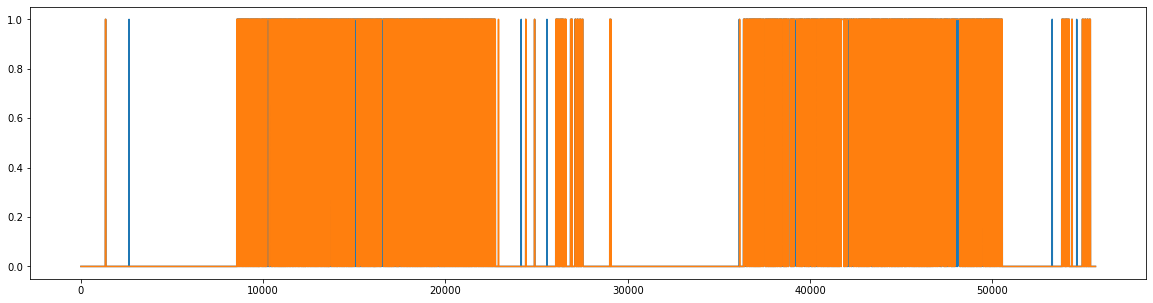

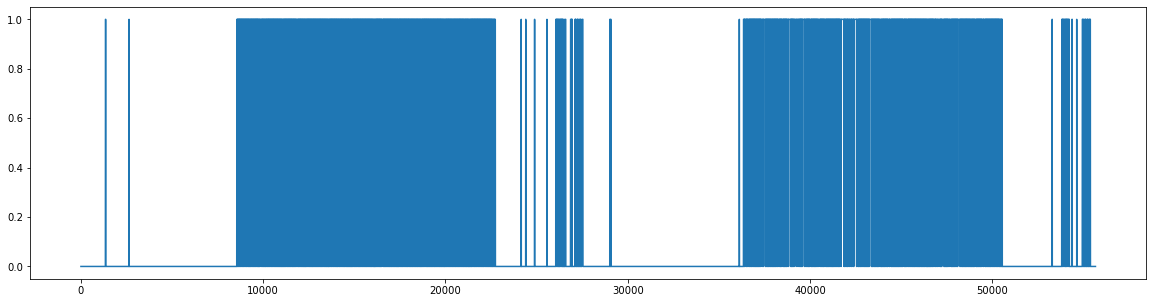

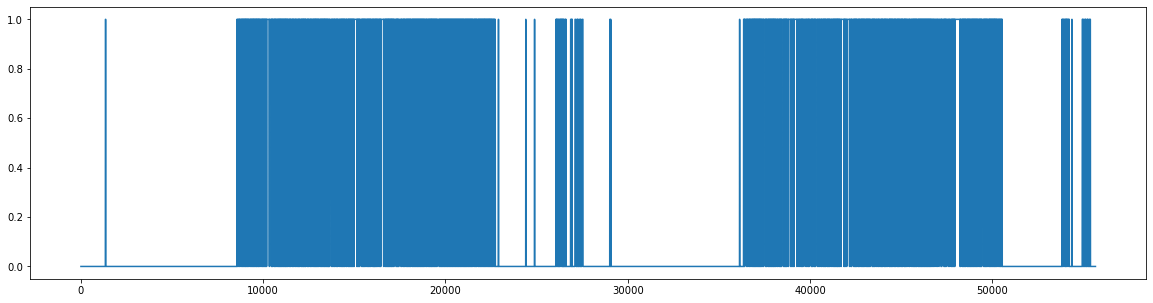

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: dct
######################################################################
Epoch 1/5
6761/6761 [==============================] - 30s 4ms/step - loss: 0.1077 - accuracy: 0.9572
Epoch 2/5
6761/6761 [==============================] - 27s 4ms/step - loss: 0.0669 - accuracy: 0.9722
Epoch 3/5
6761/6761 [==============================] - 28s 4ms/step - loss: 0.0588 - accuracy: 0.9756
Epoch 4/5
6761/6761 [==============================] - 36s 5ms/step - loss: 0.0560 - accuracy: 0.9771
Epoch 5/5
174/174 [==============================] - 1s 2ms/step - loss: 0.0540 - accuracy: 0.9784
(55660,) (55660,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.05395074561238289, 0.978440523147583]
Real test data score:  0.9283866331297161


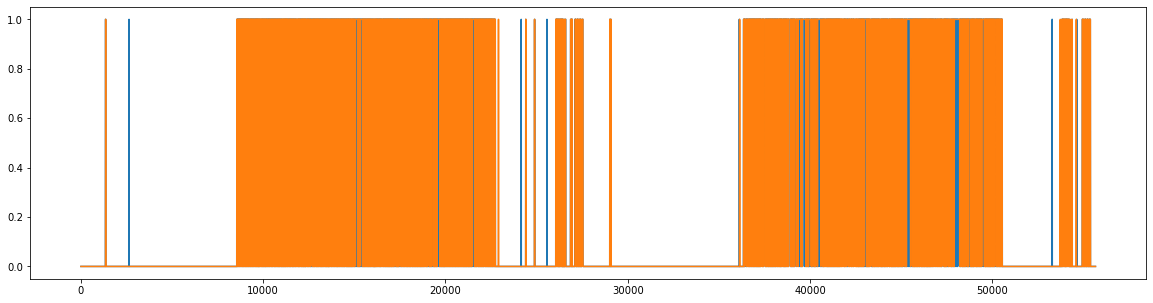

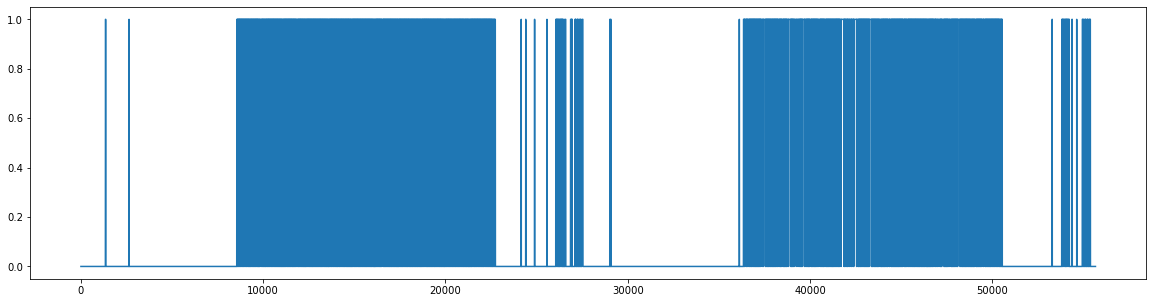

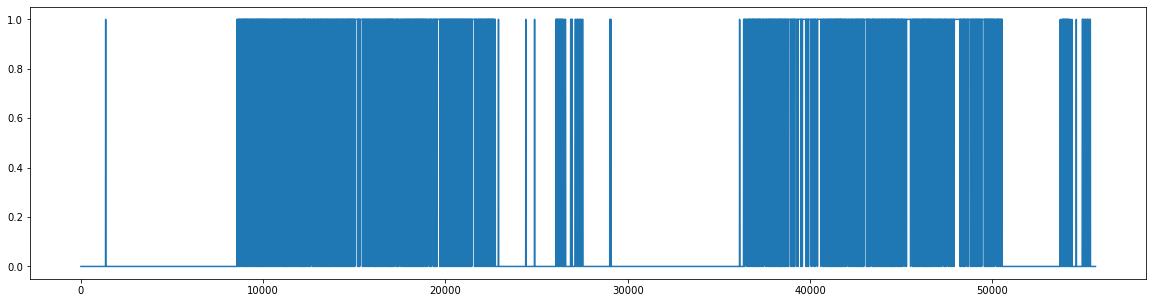

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: fft
######################################################################
Epoch 1/5
6761/6761 [==============================] - 27s 4ms/step - loss: 0.1161 - accuracy: 0.9556
Epoch 2/5
6761/6761 [==============================] - 31s 5ms/step - loss: 0.0727 - accuracy: 0.9691
Epoch 3/5
6761/6761 [==============================] - 33s 5ms/step - loss: 0.0696 - accuracy: 0.9707
Epoch 4/5
6761/6761 [==============================] - 29s 4ms/step - loss: 0.0657 - accuracy: 0.9721
Epoch 5/5
174/174 [==============================] - 0s 2ms/step - loss: 0.0723 - accuracy: 0.9669
(55660,) (55660,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.07231216132640839, 0.9669421315193176]
Real test data score:  0.9248652533237514


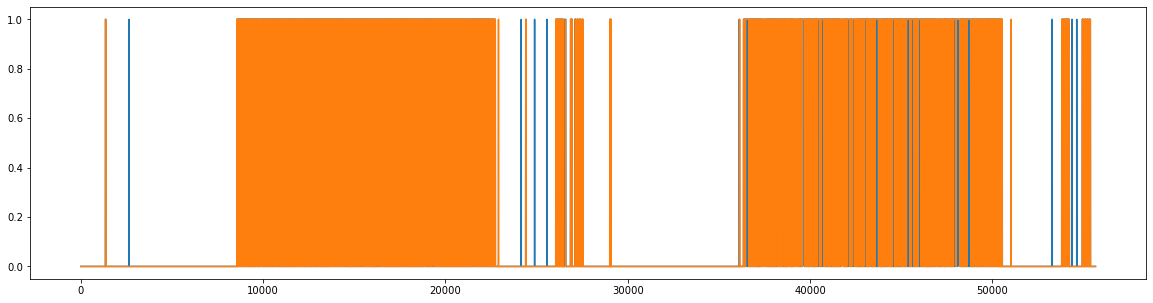

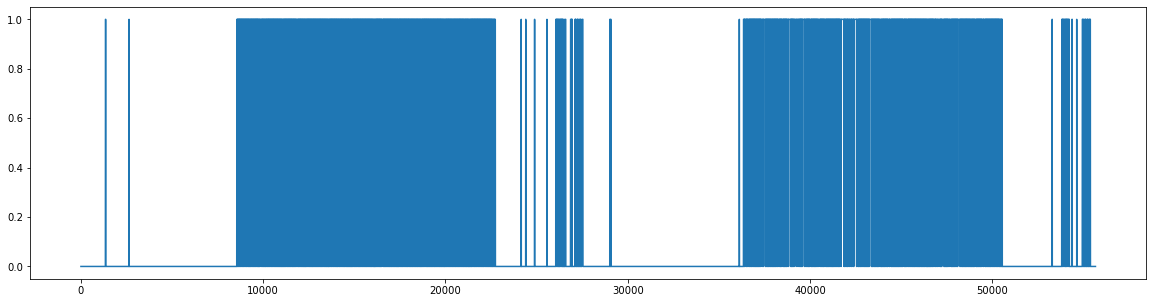

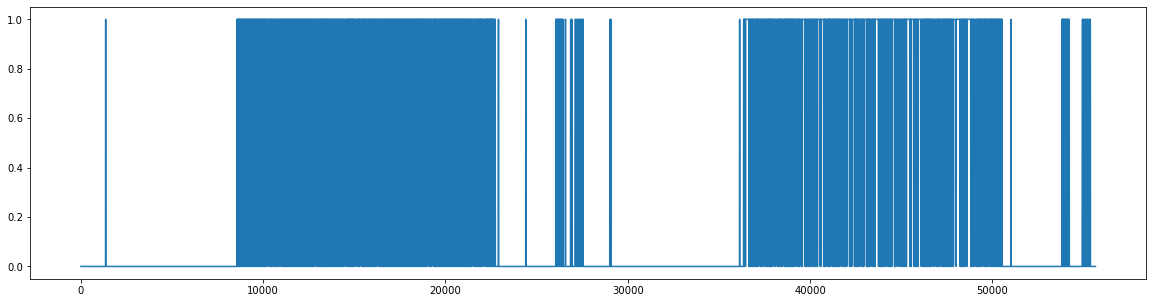

In [19]:
window_size, skip_size = 10, 10*1
formatted_frames = None
for window_type in ['fixed']: 
    data_formattor = FormatData(DATA_PATH)
    if window_type == 'vary':
        formatted_frames = data_formattor(window_type=window_type)
        df_test = formatted_frames['df_test']
        test_var_frames = formatted_frames['test_frames']  
    elif window_type == 'fixed':
        formatted_frames = data_formattor(window_type='fixed', window_size=window_size, skip_size=skip_size)
    for transform_type in [None, 'dct', 'fft']:
        print('#'*70)
        print('WINDOW TYPE: {} - TRANSFORM TYPE: {}'.format(window_type, transform_type))
        print('#'*70)
        model_trainer = CNNModelTrain(formatted_frames, window_type, transform_type)
        model_trainer()

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: None
######################################################################
Epoch 1/5
13522/13522 [==============================] - 31s 2ms/step - loss: 0.0919 - accuracy: 0.9658
Epoch 2/5
13522/13522 [==============================] - 31s 2ms/step - loss: 0.0596 - accuracy: 0.9762
Epoch 3/5
13522/13522 [==============================] - 31s 2ms/step - loss: 0.0551 - accuracy: 0.9780
Epoch 4/5
13522/13522 [==============================] - 31s 2ms/step - loss: 0.0528 - accuracy: 0.9790
Epoch 5/5
348/348 [==============================] - 1s 1ms/step - loss: 0.0471 - accuracy: 0.9801
(55665,) (55665,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.04707304388284683, 0.9801490902900696]
Real test data score:  0.9580885655259139


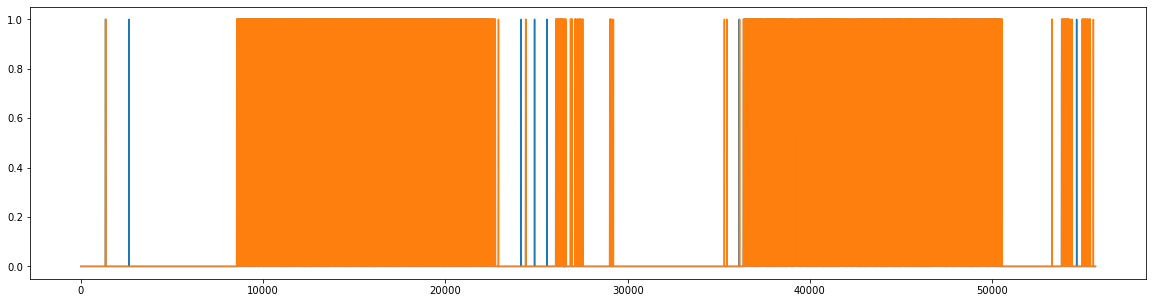

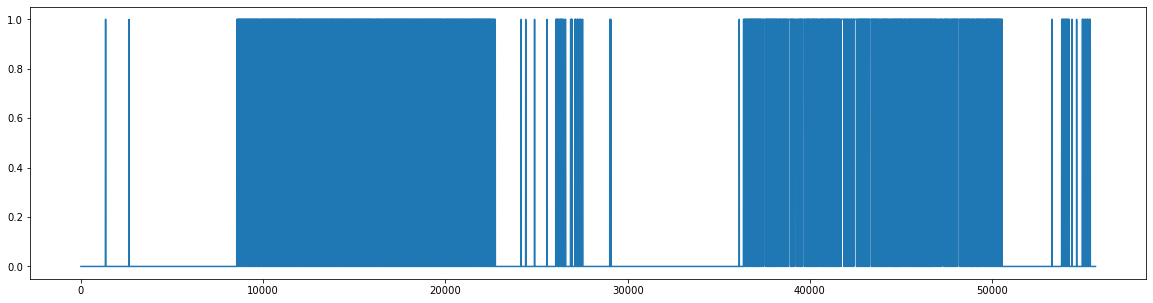

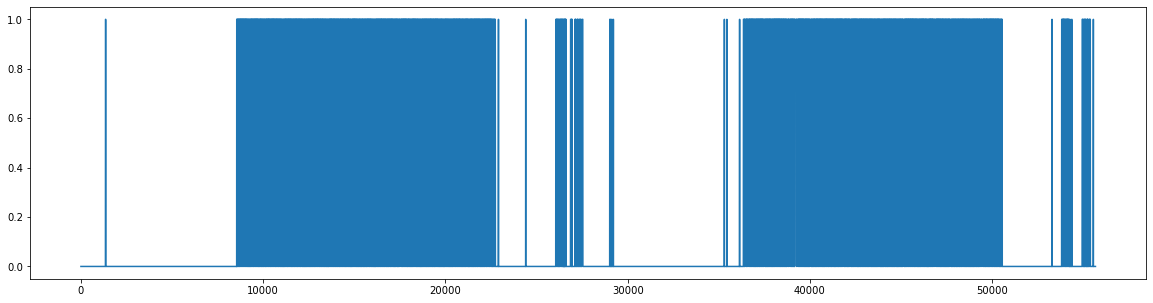

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: dct
######################################################################
Epoch 1/5
13522/13522 [==============================] - 32s 2ms/step - loss: 0.0900 - accuracy: 0.9651
Epoch 2/5
13522/13522 [==============================] - 31s 2ms/step - loss: 0.0629 - accuracy: 0.9746
Epoch 3/5
13522/13522 [==============================] - 31s 2ms/step - loss: 0.0581 - accuracy: 0.9766
Epoch 4/5
13522/13522 [==============================] - 30s 2ms/step - loss: 0.0553 - accuracy: 0.9776
Epoch 5/5
348/348 [==============================] - 1s 1ms/step - loss: 0.0477 - accuracy: 0.9784
(55665,) (55665,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.04765591397881508, 0.9783526659011841]
Real test data score:  0.9574418395760352


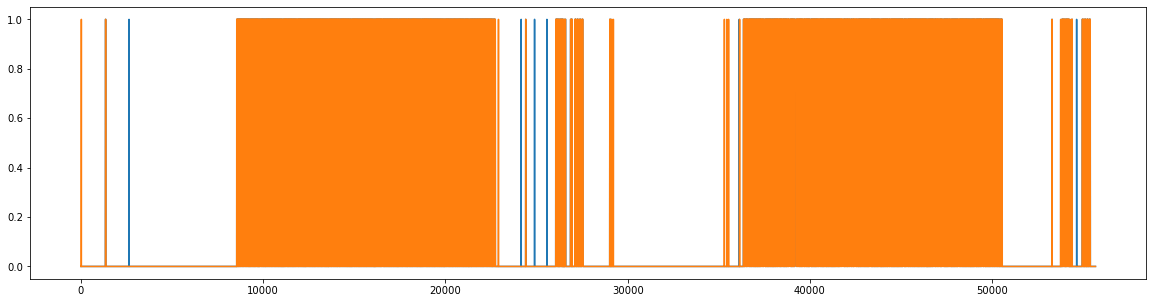

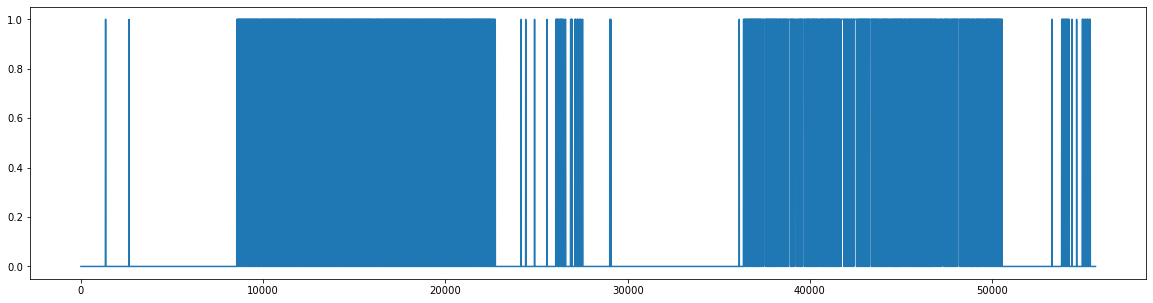

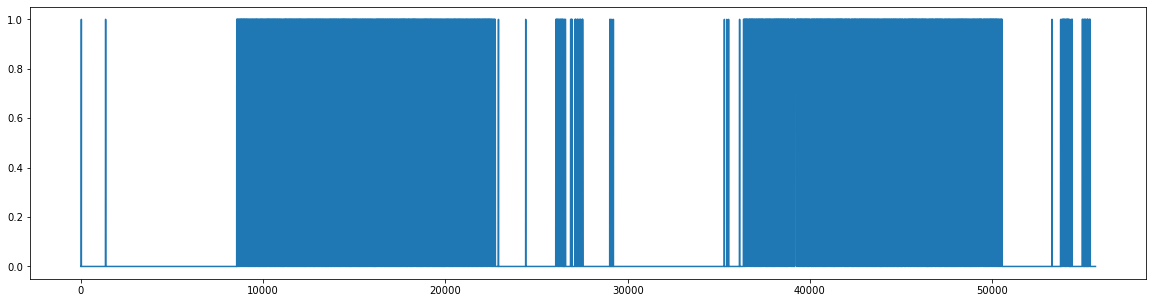

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: fft
######################################################################
Epoch 1/5
13522/13522 [==============================] - 31s 2ms/step - loss: 0.0895 - accuracy: 0.9648
Epoch 2/5
13522/13522 [==============================] - 34s 3ms/step - loss: 0.0673 - accuracy: 0.9722
Epoch 3/5
13522/13522 [==============================] - 29s 2ms/step - loss: 0.0642 - accuracy: 0.9734
Epoch 4/5
13522/13522 [==============================] - 30s 2ms/step - loss: 0.0616 - accuracy: 0.9745
Epoch 5/5
348/348 [==============================] - 1s 1ms/step - loss: 0.0539 - accuracy: 0.9769
(55665,) (55665,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.05388203635811806, 0.9769154787063599]
Real test data score:  0.957477768795473


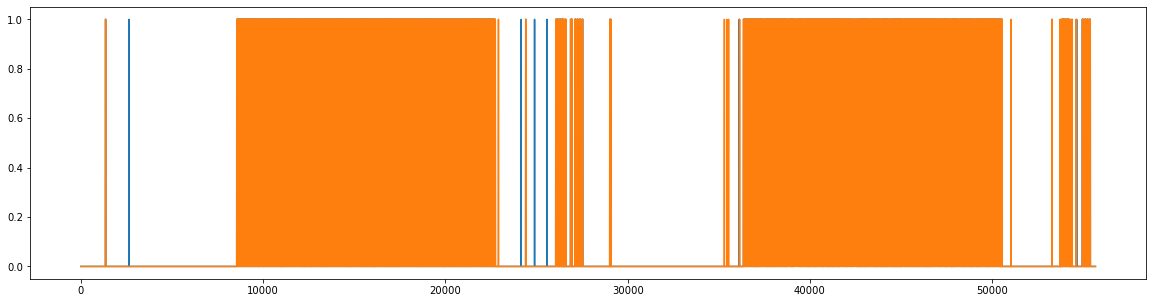

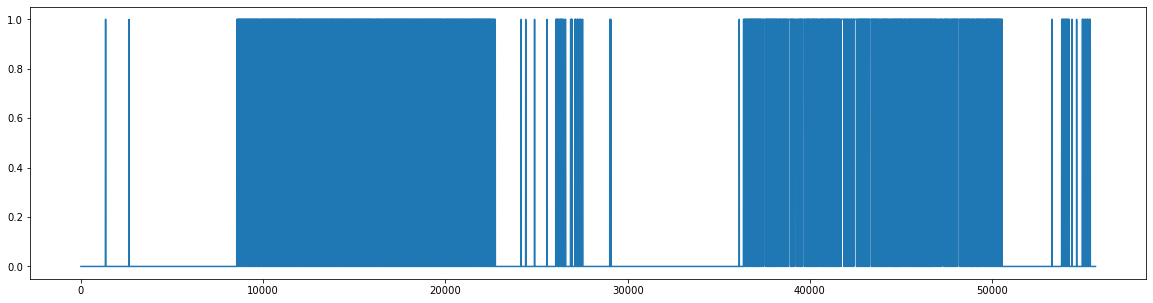

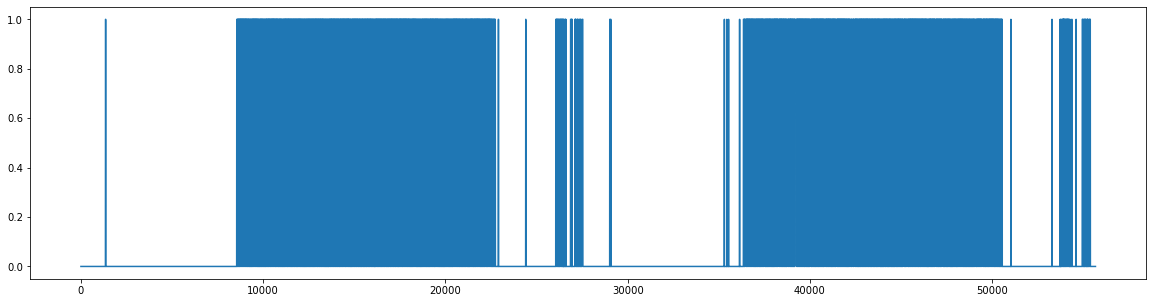

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: None
######################################################################
Epoch 1/5
4508/4508 [==============================] - 29s 6ms/step - loss: 0.0938 - accuracy: 0.9625
Epoch 2/5
4508/4508 [==============================] - 27s 6ms/step - loss: 0.0560 - accuracy: 0.9768
Epoch 3/5
4508/4508 [==============================] - 28s 6ms/step - loss: 0.0504 - accuracy: 0.9795
Epoch 4/5
4508/4508 [==============================] - 28s 6ms/step - loss: 0.0472 - accuracy: 0.9805
Epoch 5/5
116/116 [==============================] - 0s 3ms/step - loss: 0.0659 - accuracy: 0.9696
(55665,) (55665,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.06591306626796722, 0.9695500135421753]
Real test data score:  0.9018773017156202


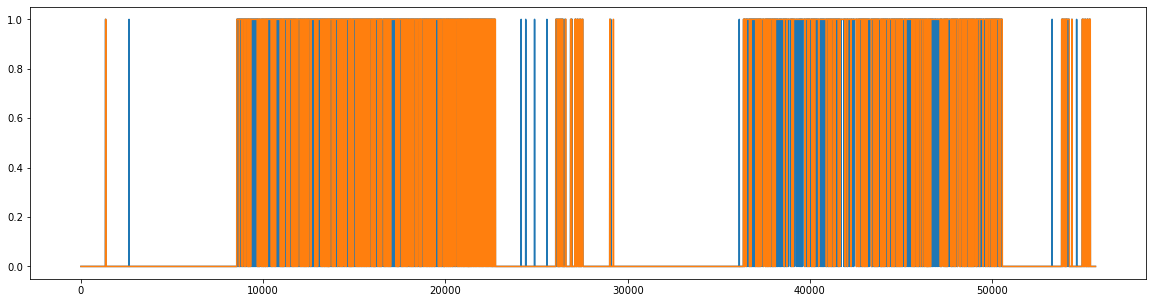

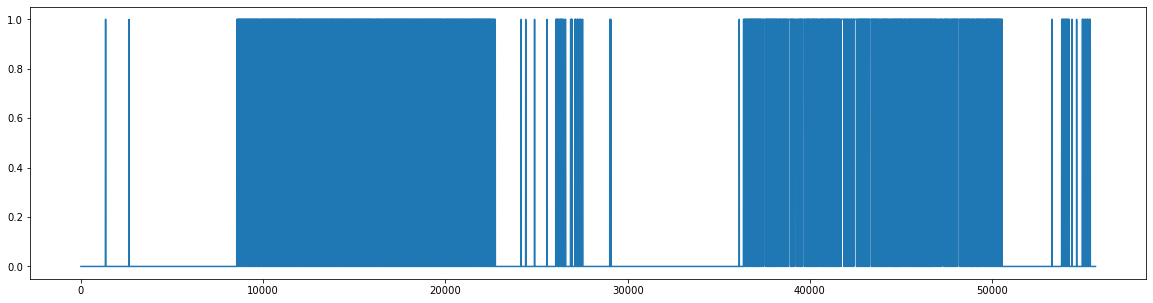

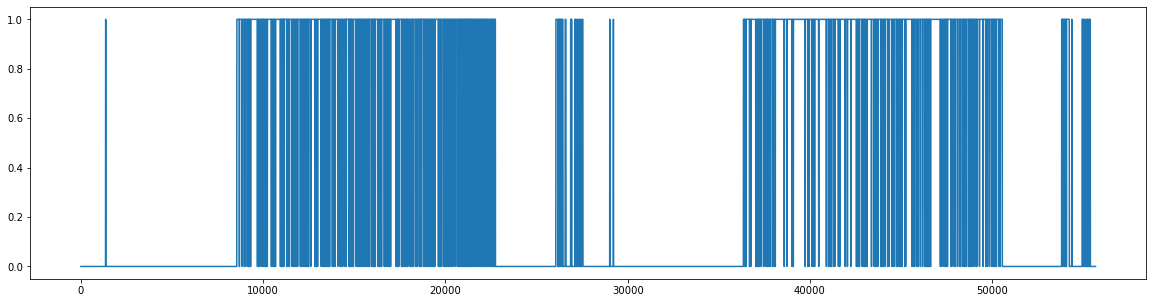

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: dct
######################################################################
Epoch 1/5
4508/4508 [==============================] - 26s 6ms/step - loss: 0.1317 - accuracy: 0.9494
Epoch 2/5
4508/4508 [==============================] - 25s 6ms/step - loss: 0.0747 - accuracy: 0.9689
Epoch 3/5
4508/4508 [==============================] - 25s 6ms/step - loss: 0.0682 - accuracy: 0.9717
Epoch 4/5
4508/4508 [==============================] - 25s 6ms/step - loss: 0.0643 - accuracy: 0.9738
Epoch 5/5
116/116 [==============================] - 1s 2ms/step - loss: 0.1279 - accuracy: 0.9464
(55665,) (55665,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.12790147960186005, 0.9463756680488586]
Real test data score:  0.8972065031887182


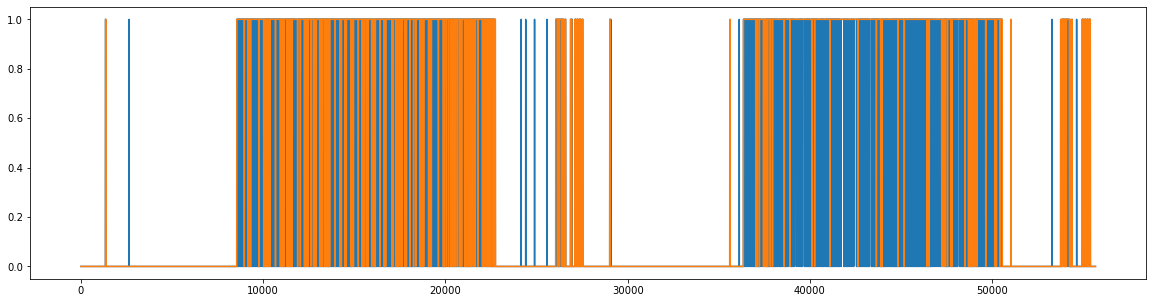

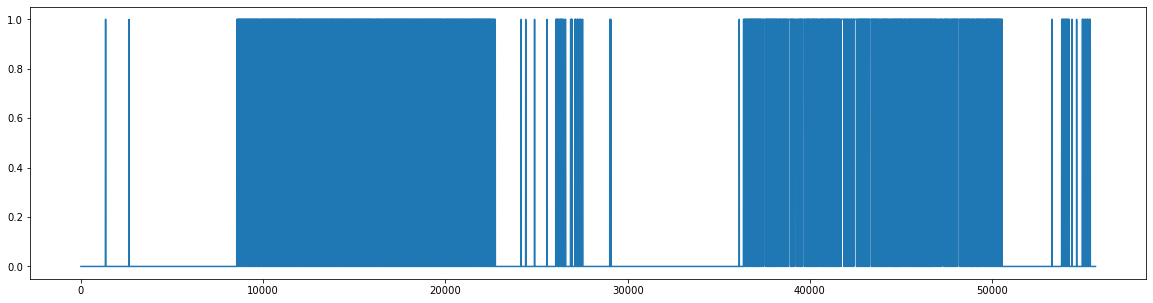

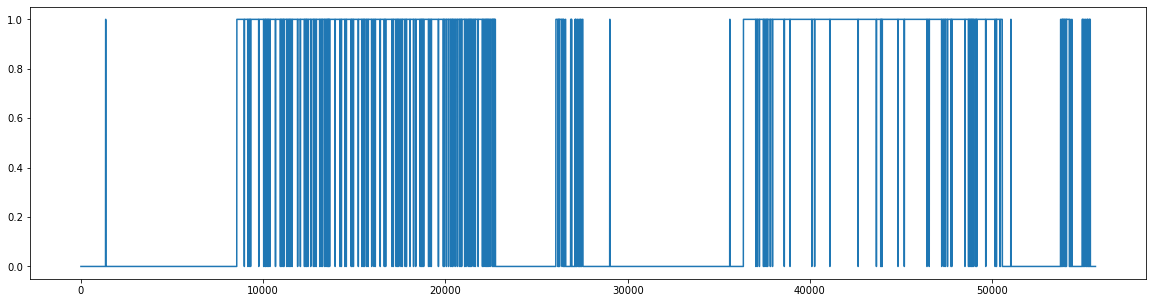

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: fft
######################################################################
Epoch 1/5
4508/4508 [==============================] - 33s 7ms/step - loss: 0.1220 - accuracy: 0.9531
Epoch 2/5
4508/4508 [==============================] - 29s 6ms/step - loss: 0.0737 - accuracy: 0.9692
Epoch 3/5
4508/4508 [==============================] - 28s 6ms/step - loss: 0.0699 - accuracy: 0.9711
Epoch 4/5
4508/4508 [==============================] - 28s 6ms/step - loss: 0.0656 - accuracy: 0.9719
Epoch 5/5
116/116 [==============================] - 0s 3ms/step - loss: 0.1012 - accuracy: 0.9550
(55665,) (55665,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.10123245418071747, 0.9549986720085144]
Real test data score:  0.8973142908470313


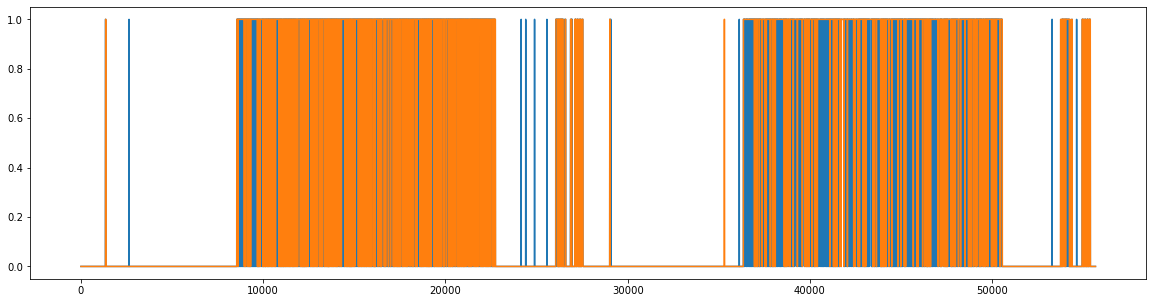

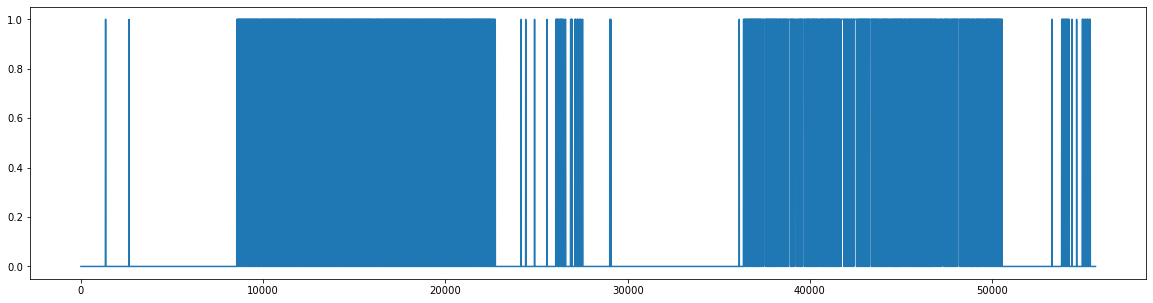

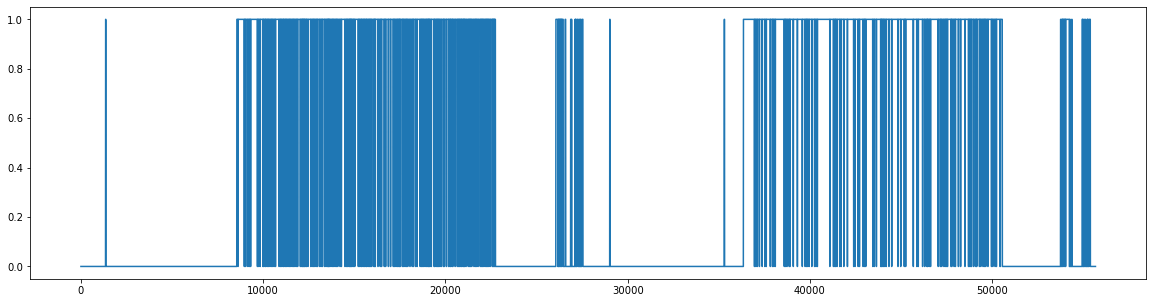

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: None
######################################################################
Epoch 1/5
3381/3381 [==============================] - 28s 8ms/step - loss: 0.1097 - accuracy: 0.9527
Epoch 2/5
3381/3381 [==============================] - 27s 8ms/step - loss: 0.0660 - accuracy: 0.9712
Epoch 3/5
3381/3381 [==============================] - 27s 8ms/step - loss: 0.0618 - accuracy: 0.9732
Epoch 4/5
3381/3381 [==============================] - 27s 8ms/step - loss: 0.0564 - accuracy: 0.9759
Epoch 5/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0604 - accuracy: 0.9702
(55660,) (55660,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.06040069833397865, 0.9701760411262512]
Real test data score:  0.8882860222781171


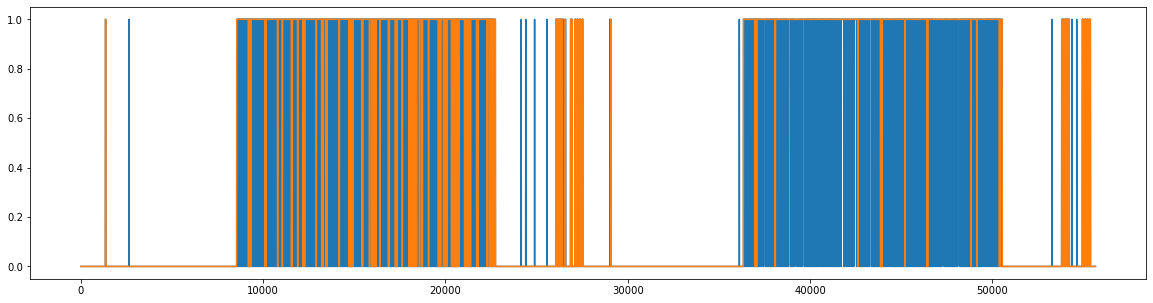

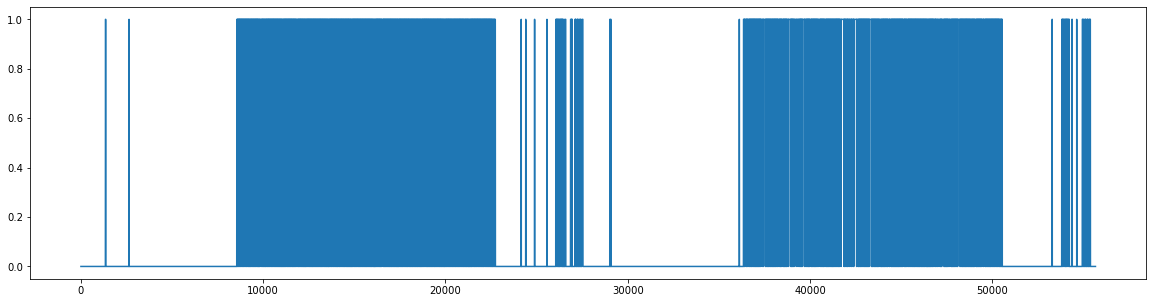

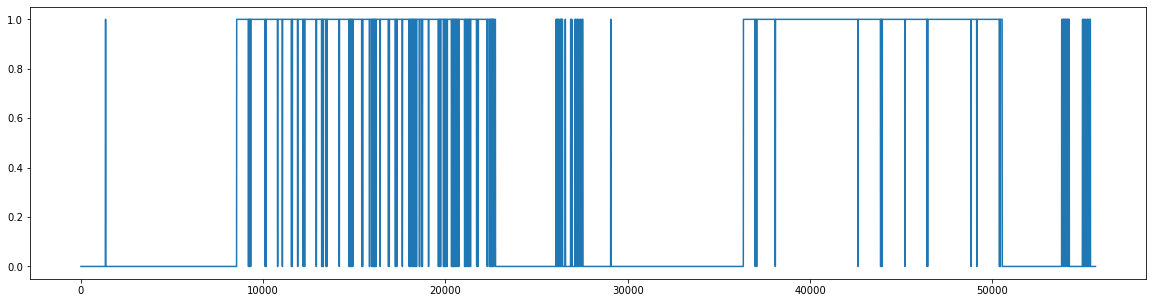

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: dct
######################################################################
Epoch 1/5
3381/3381 [==============================] - 27s 8ms/step - loss: 0.1461 - accuracy: 0.9427
Epoch 2/5
3381/3381 [==============================] - 27s 8ms/step - loss: 0.0944 - accuracy: 0.9584
Epoch 3/5
3381/3381 [==============================] - 29s 9ms/step - loss: 0.0843 - accuracy: 0.9630
Epoch 4/5
3381/3381 [==============================] - 27s 8ms/step - loss: 0.0824 - accuracy: 0.9636
Epoch 5/5
87/87 [==============================] - 0s 3ms/step - loss: 0.0656 - accuracy: 0.9738
(55660,) (55660,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.06558304280042648, 0.9737693071365356]
Real test data score:  0.8887172116421128


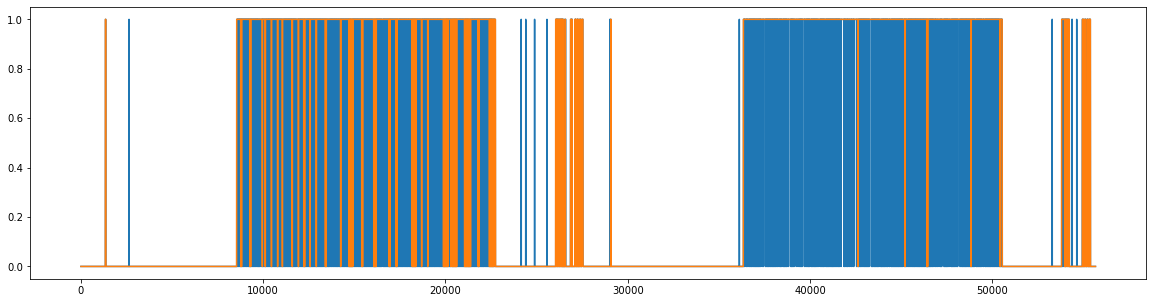

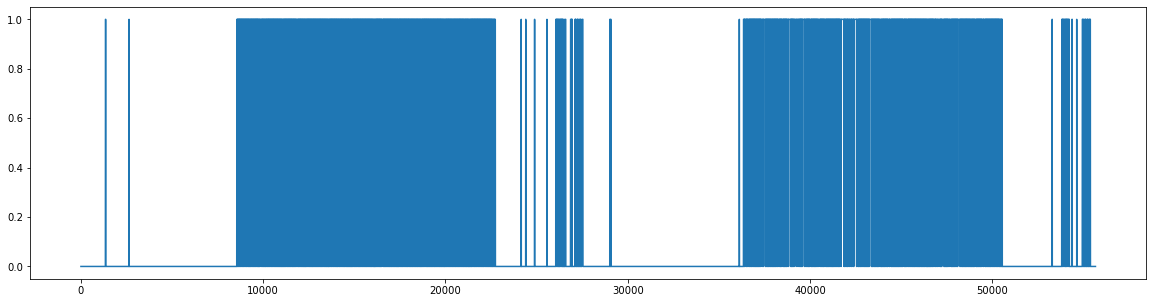

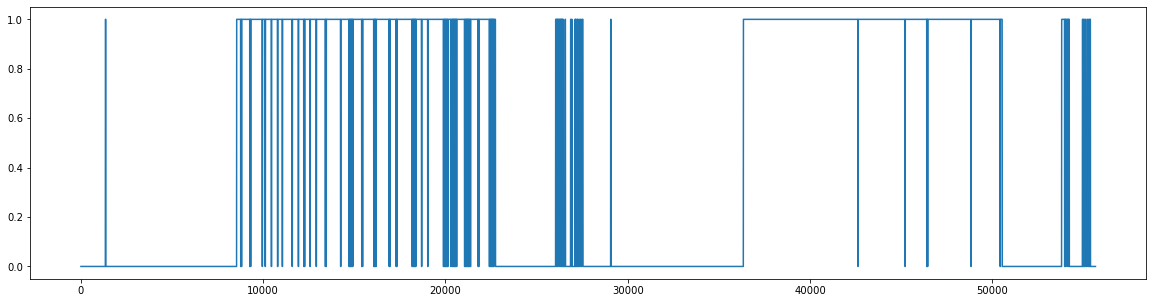

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: fft
######################################################################
Epoch 1/5
3381/3381 [==============================] - 27s 8ms/step - loss: 0.1543 - accuracy: 0.9382
Epoch 2/5
3381/3381 [==============================] - 26s 8ms/step - loss: 0.0898 - accuracy: 0.9615
Epoch 3/5
3381/3381 [==============================] - 26s 8ms/step - loss: 0.0870 - accuracy: 0.9620
Epoch 4/5
3381/3381 [==============================] - 27s 8ms/step - loss: 0.0833 - accuracy: 0.9636
Epoch 5/5
87/87 [==============================] - 1s 3ms/step - loss: 0.0705 - accuracy: 0.9738
(55660,) (55660,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.07049024105072021, 0.9737693071365356]
Real test data score:  0.888501616960115


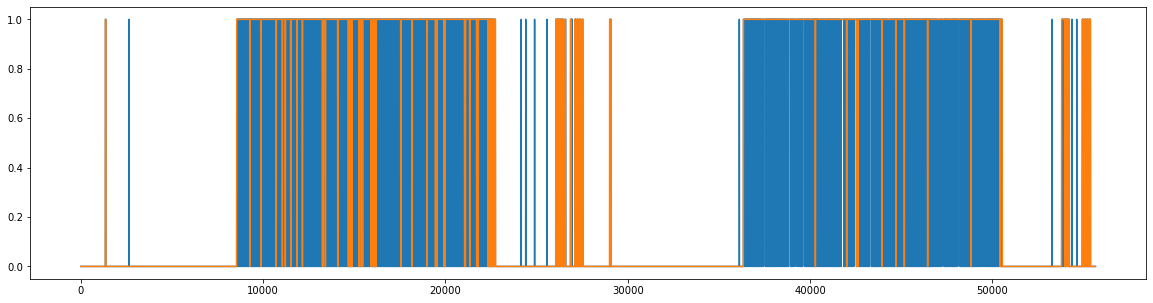

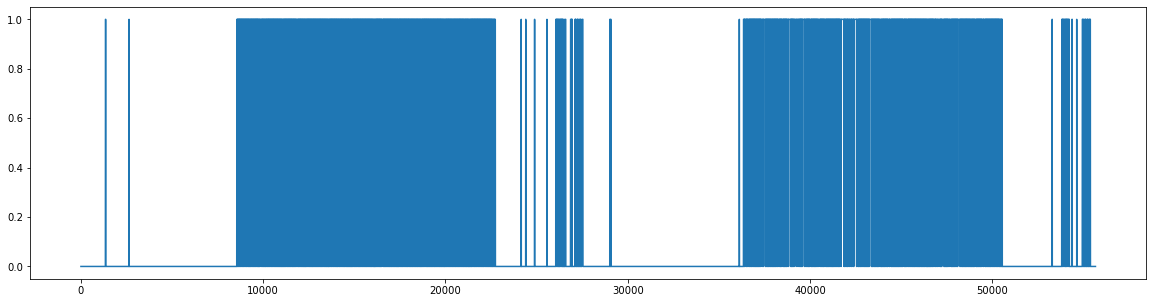

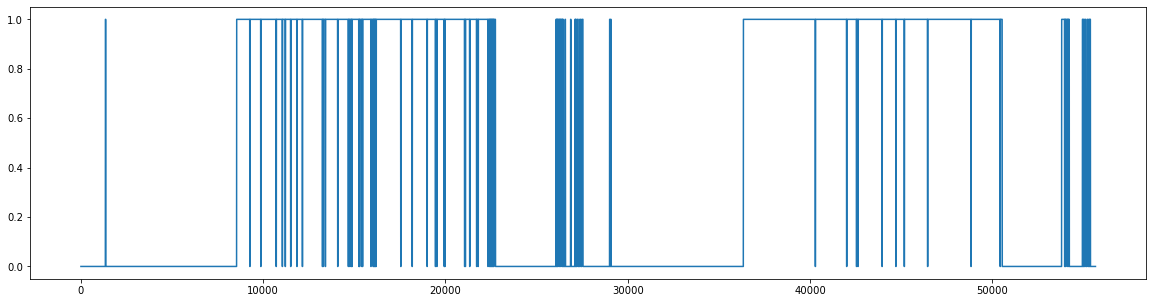

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: None
######################################################################
Epoch 1/5
2705/2705 [==============================] - 27s 10ms/step - loss: 0.1100 - accuracy: 0.9540
Epoch 2/5
2705/2705 [==============================] - 26s 10ms/step - loss: 0.0616 - accuracy: 0.9745
Epoch 3/5
2705/2705 [==============================] - 26s 10ms/step - loss: 0.0589 - accuracy: 0.9749
Epoch 4/5
2705/2705 [==============================] - 26s 10ms/step - loss: 0.0560 - accuracy: 0.97640s
Epoch 5/5
70/70 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9946
(55650,) (55650,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.015303706750273705, 0.9946091771125793]
Real test data score:  0.8886792452830189


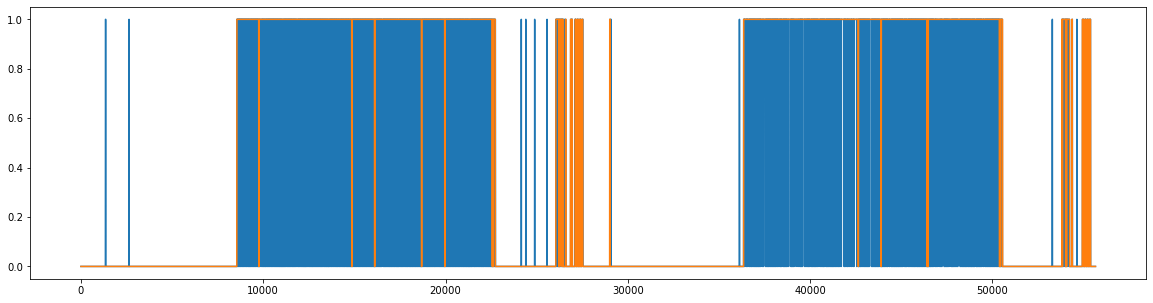

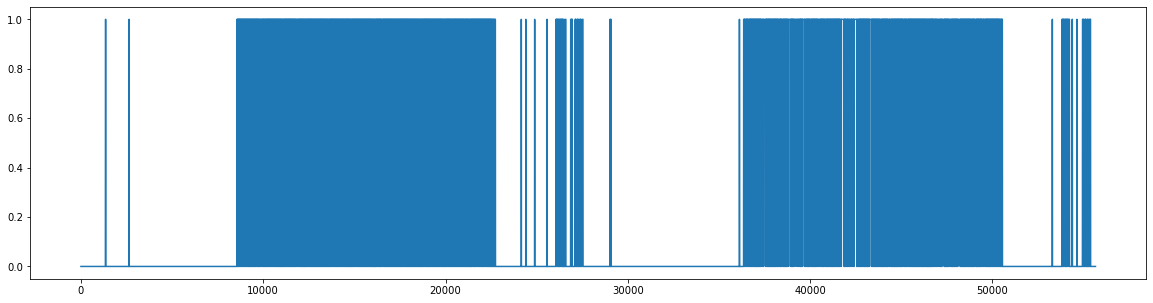

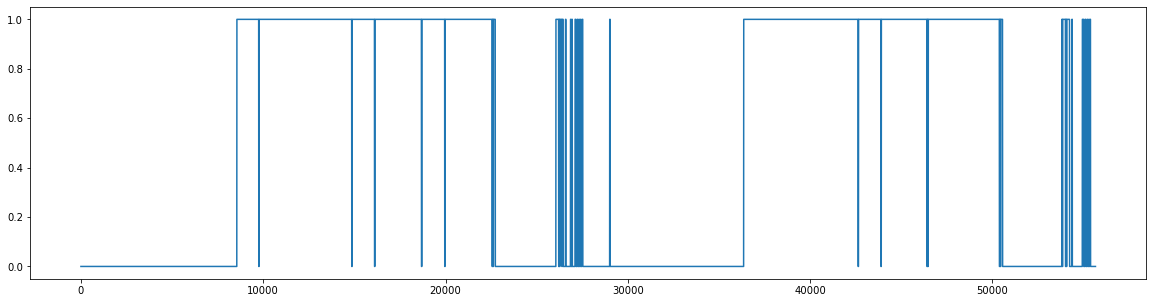

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: dct
######################################################################
Epoch 1/5
2705/2705 [==============================] - 26s 9ms/step - loss: 0.1465 - accuracy: 0.9471
Epoch 2/5
2705/2705 [==============================] - 26s 10ms/step - loss: 0.0868 - accuracy: 0.9635
Epoch 3/5
2705/2705 [==============================] - 26s 9ms/step - loss: 0.0811 - accuracy: 0.9660
Epoch 4/5
2705/2705 [==============================] - 26s 9ms/step - loss: 0.0769 - accuracy: 0.9676
Epoch 5/5
70/70 [==============================] - 1s 6ms/step - loss: 0.0320 - accuracy: 0.9906
(55650,) (55650,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.03200489282608032, 0.9905660152435303]
Real test data score:  0.8876190476190476


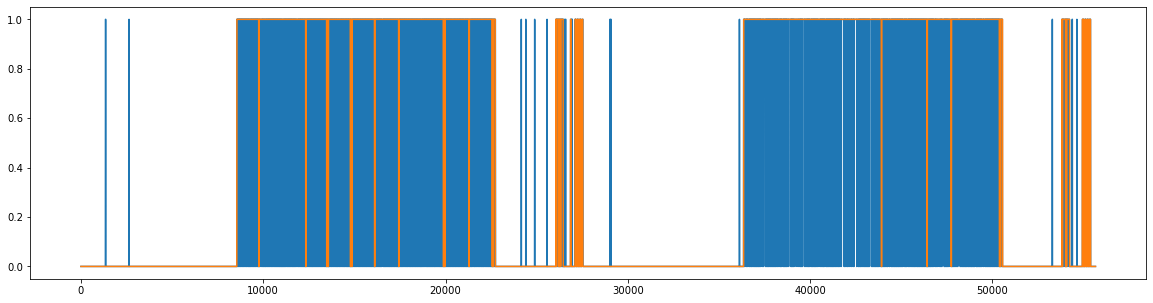

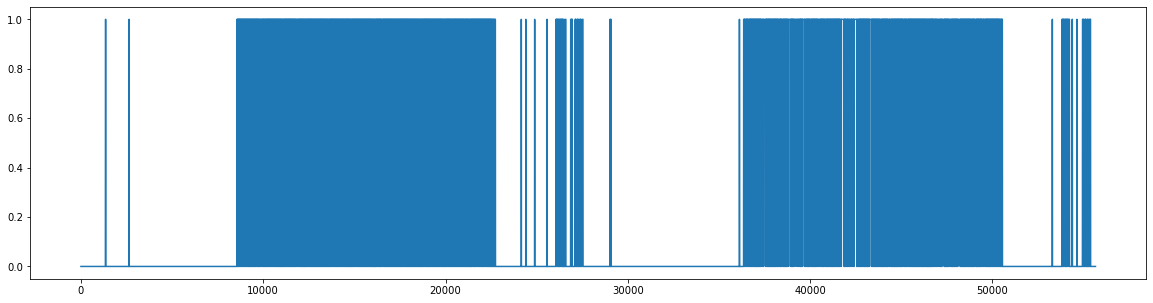

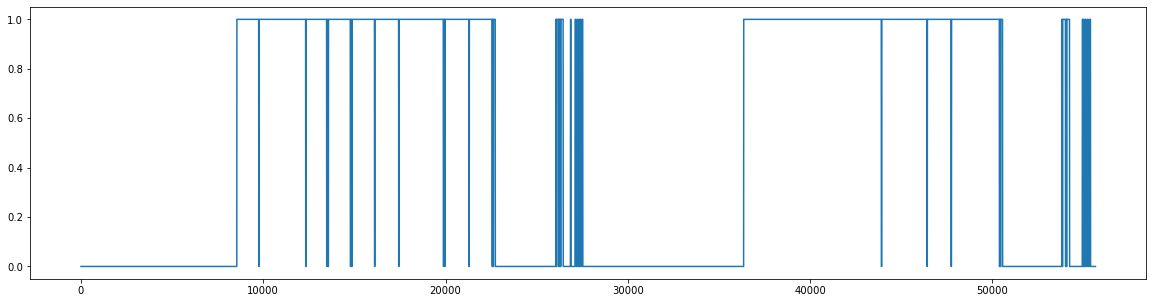

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: fft
######################################################################
Epoch 1/5
2705/2705 [==============================] - 41s 14ms/step - loss: 0.1606 - accuracy: 0.9435
Epoch 2/5
2705/2705 [==============================] - 29s 11ms/step - loss: 0.0842 - accuracy: 0.9654
Epoch 3/5
2705/2705 [==============================] - 26s 10ms/step - loss: 0.0801 - accuracy: 0.9664
Epoch 4/5
2705/2705 [==============================] - 26s 10ms/step - loss: 0.0767 - accuracy: 0.9681
Epoch 5/5
70/70 [==============================] - 0s 3ms/step - loss: 0.0335 - accuracy: 0.9915
(55650,) (55650,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.03349084407091141, 0.9914644956588745]
Real test data score:  0.8872237196765499


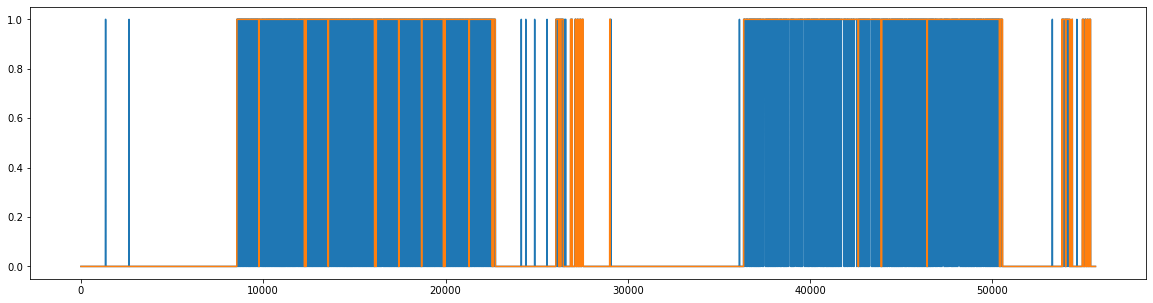

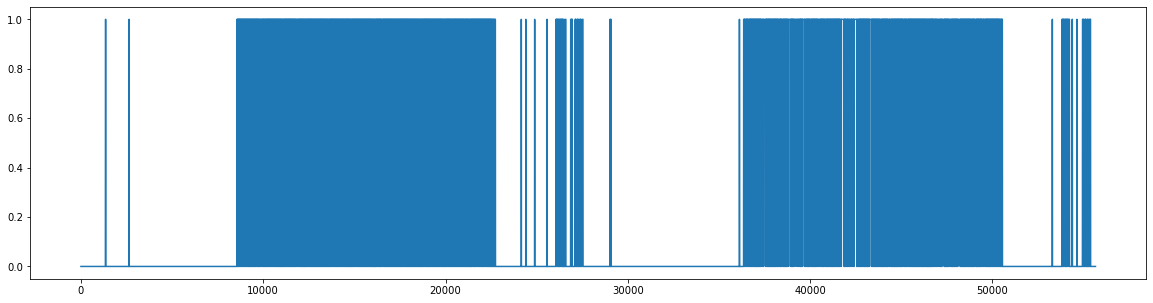

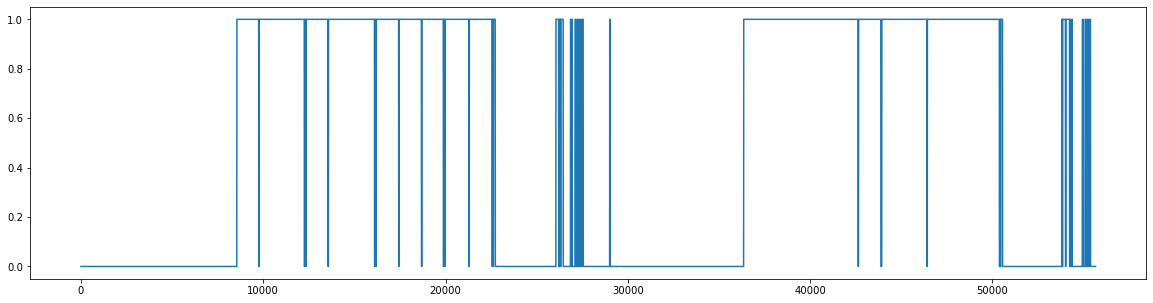

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: None
######################################################################
Epoch 1/5
2254/2254 [==============================] - 23s 10ms/step - loss: 0.1261 - accuracy: 0.9478
Epoch 2/5
2254/2254 [==============================] - 22s 10ms/step - loss: 0.0601 - accuracy: 0.9747
Epoch 3/5
2254/2254 [==============================] - 22s 10ms/step - loss: 0.0573 - accuracy: 0.9765
Epoch 4/5
2254/2254 [==============================] - 22s 10ms/step - loss: 0.0528 - accuracy: 0.9787
Epoch 5/5
58/58 [==============================] - 0s 3ms/step - loss: 0.0213 - accuracy: 0.9930
(55650,) (55650,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.02128427103161812, 0.9929919242858887]
Real test data score:  0.8872237196765499


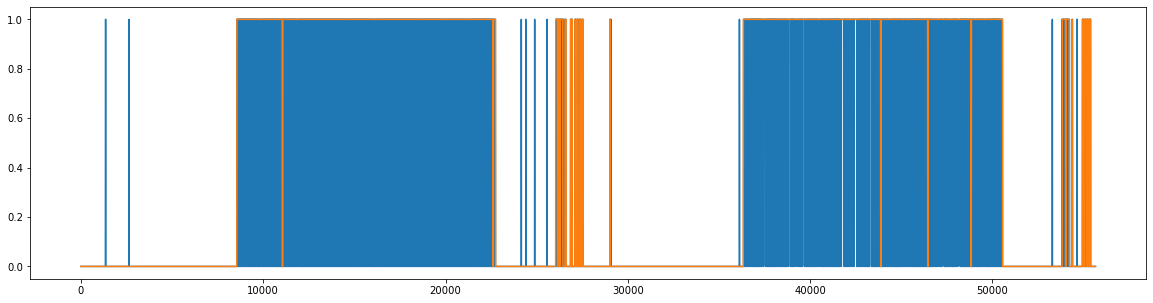

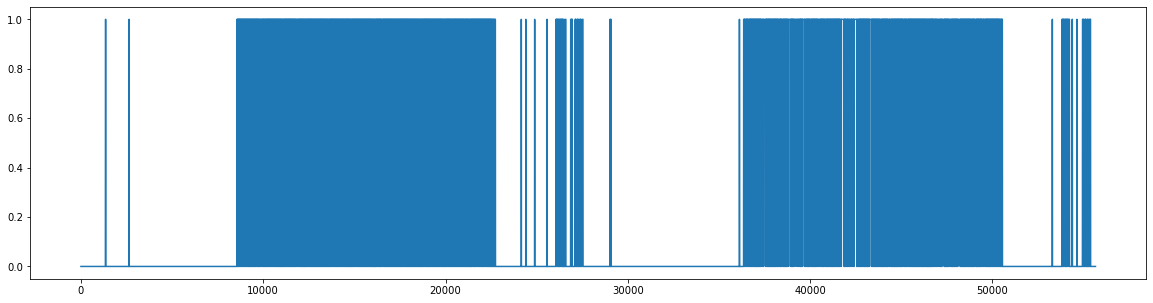

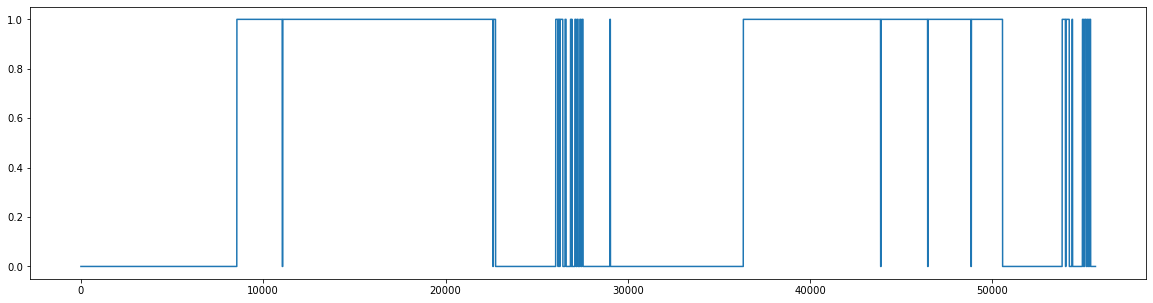

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: dct
######################################################################
Epoch 1/5
2254/2254 [==============================] - 24s 10ms/step - loss: 0.1692 - accuracy: 0.9410
Epoch 2/5
2254/2254 [==============================] - 21s 9ms/step - loss: 0.0875 - accuracy: 0.9638
Epoch 3/5
2254/2254 [==============================] - 22s 10ms/step - loss: 0.0790 - accuracy: 0.9681
Epoch 4/5
2254/2254 [==============================] - 22s 10ms/step - loss: 0.0785 - accuracy: 0.9684
Epoch 5/5
58/58 [==============================] - 0s 2ms/step - loss: 0.0416 - accuracy: 0.9849
(55650,) (55650,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.04162636026740074, 0.9849056601524353]
Real test data score:  0.8843845462713388


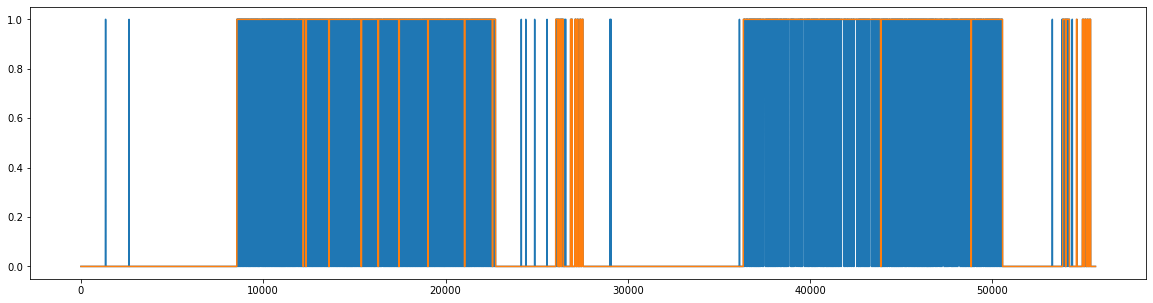

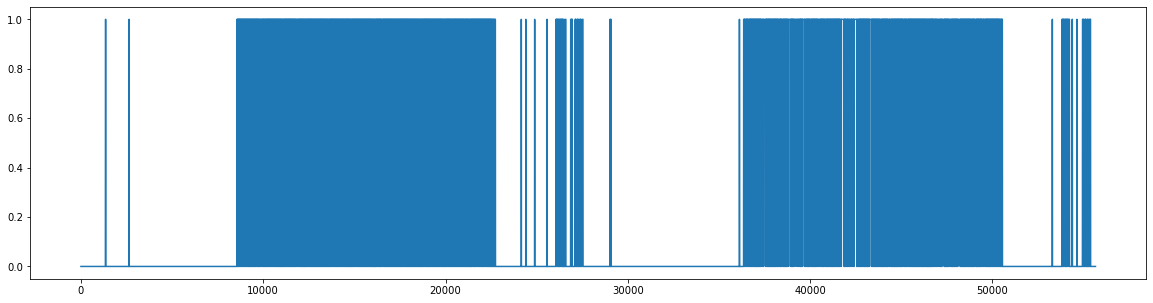

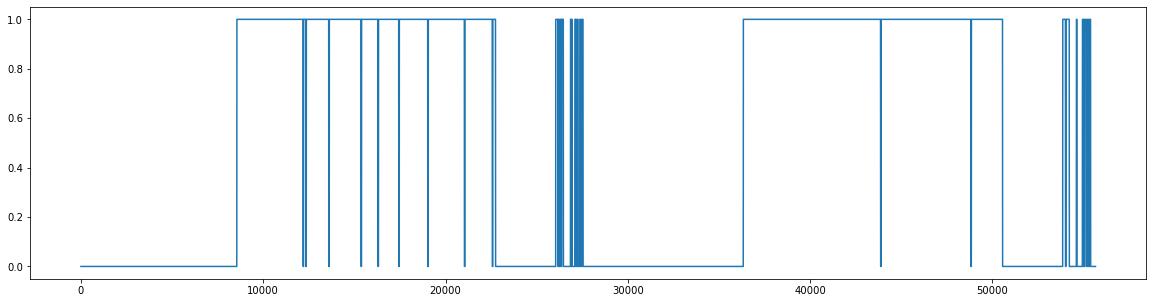

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: fft
######################################################################
Epoch 1/5
2254/2254 [==============================] - 23s 10ms/step - loss: 0.1683 - accuracy: 0.9376
Epoch 2/5
2254/2254 [==============================] - 22s 10ms/step - loss: 0.0881 - accuracy: 0.9648
Epoch 3/5
2254/2254 [==============================] - 22s 10ms/step - loss: 0.0863 - accuracy: 0.9655
Epoch 4/5
2254/2254 [==============================] - 22s 10ms/step - loss: 0.0787 - accuracy: 0.9674
Epoch 5/5
58/58 [==============================] - 0s 3ms/step - loss: 0.0509 - accuracy: 0.9806
(55650,) (55650,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.05091933533549309, 0.9805929660797119]
Real test data score:  0.8820125786163522


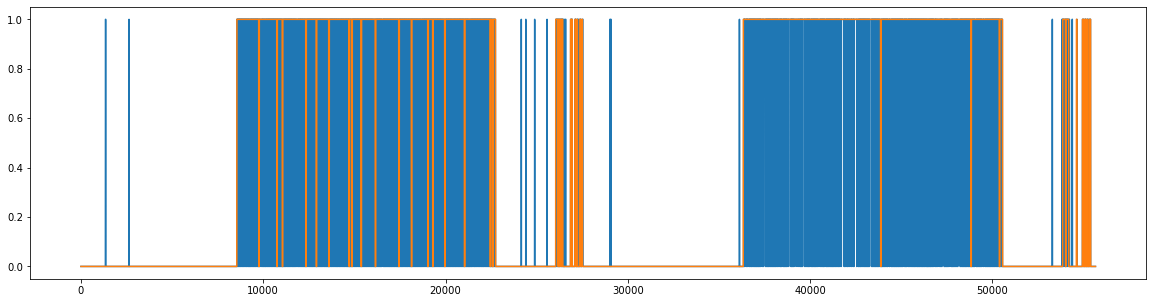

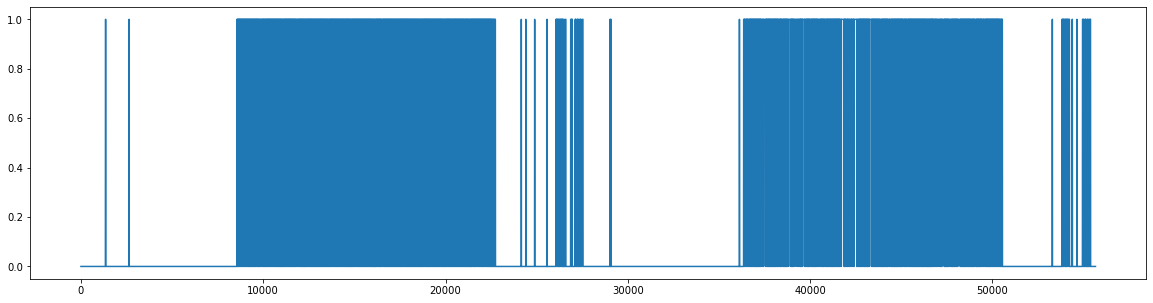

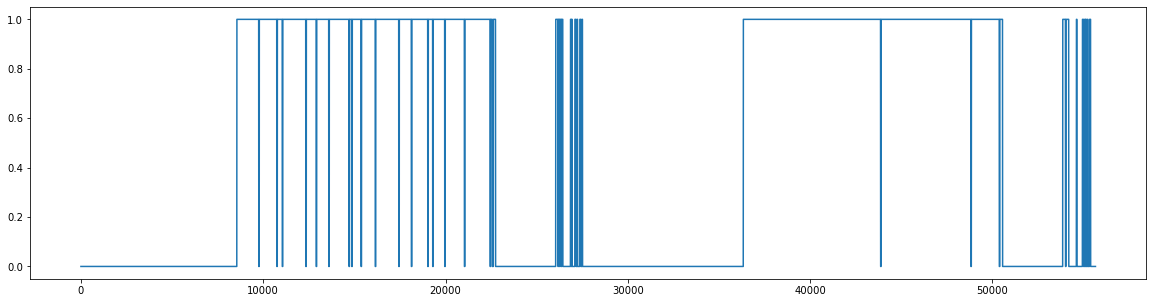

In [20]:
window_size_list = [5, 15, 20, 25, 30]
window_type = 'fixed'
formatted_frames = None
for window_size in window_size_list: 
    skip_size = window_size
    data_formattor = FormatData(DATA_PATH)
    formatted_frames = data_formattor(window_type, window_size=window_size, skip_size=skip_size)
    for transform_type in [None, 'dct', 'fft']:
        print('#'*70)
        print('WINDOW TYPE: {} - TRANSFORM TYPE: {}'.format(window_type, transform_type))
        print('#'*70)
        model_trainer = CNNModelTrain(formatted_frames, window_type, transform_type)
        model_trainer()

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: None - WINDOW SIZE: 6
######################################################################
Epoch 1/5
11269/11269 [==============================] - 33s 3ms/step - loss: 0.0923 - accuracy: 0.9644
Epoch 2/5
11269/11269 [==============================] - 31s 3ms/step - loss: 0.0590 - accuracy: 0.9761
Epoch 3/5
11269/11269 [==============================] - 31s 3ms/step - loss: 0.0537 - accuracy: 0.9785
Epoch 4/5
11269/11269 [==============================] - 31s 3ms/step - loss: 0.0516 - accuracy: 0.9794
Epoch 5/5
290/290 [==============================] - 1s 1ms/step - loss: 0.0462 - accuracy: 0.9811
(55662,) (55662,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.04618388041853905, 0.98113614320755]
Real test data score:  0.9534691531026553


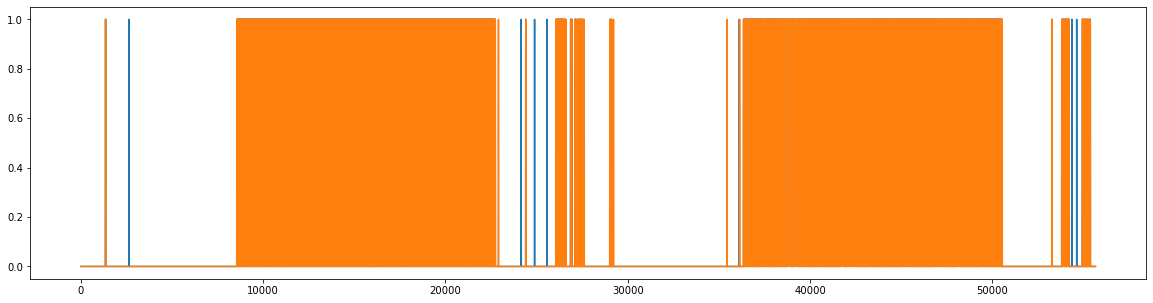

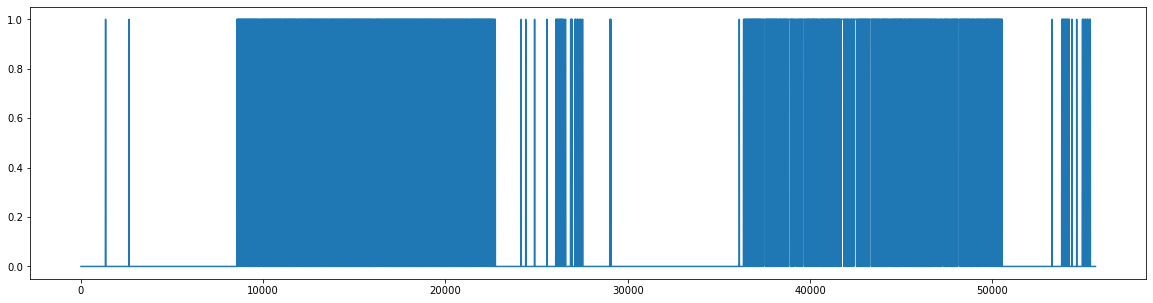

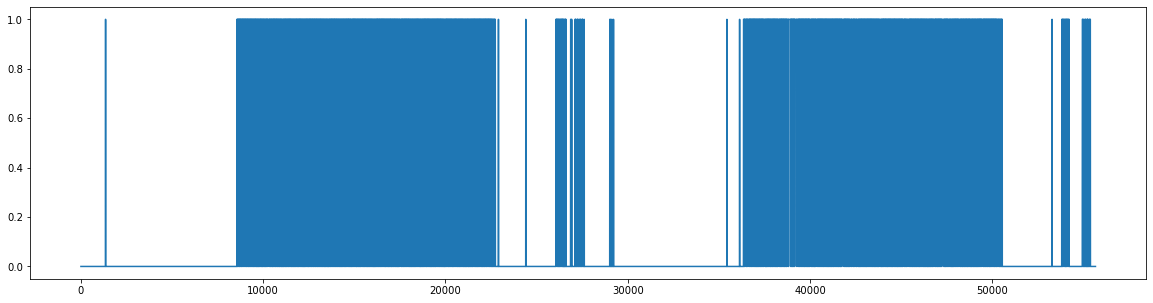

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: dct - WINDOW SIZE: 6
######################################################################
Epoch 1/5
11269/11269 [==============================] - 33s 2ms/step - loss: 0.0963 - accuracy: 0.9626
Epoch 2/5
11269/11269 [==============================] - 31s 3ms/step - loss: 0.0623 - accuracy: 0.9740
Epoch 3/5
11269/11269 [==============================] - 31s 3ms/step - loss: 0.0575 - accuracy: 0.9766
Epoch 4/5
11269/11269 [==============================] - 31s 3ms/step - loss: 0.0552 - accuracy: 0.9775
Epoch 5/5
290/290 [==============================] - 1s 1ms/step - loss: 0.0610 - accuracy: 0.9746
(55662,) (55662,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.06099360063672066, 0.9745607376098633]
Real test data score:  0.9523193561136861


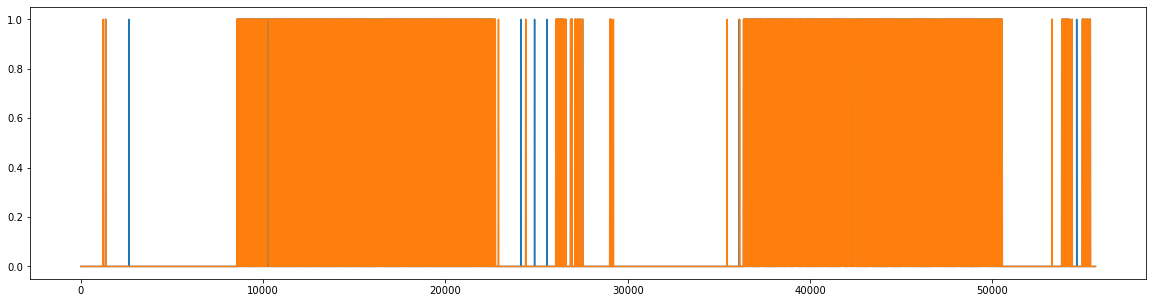

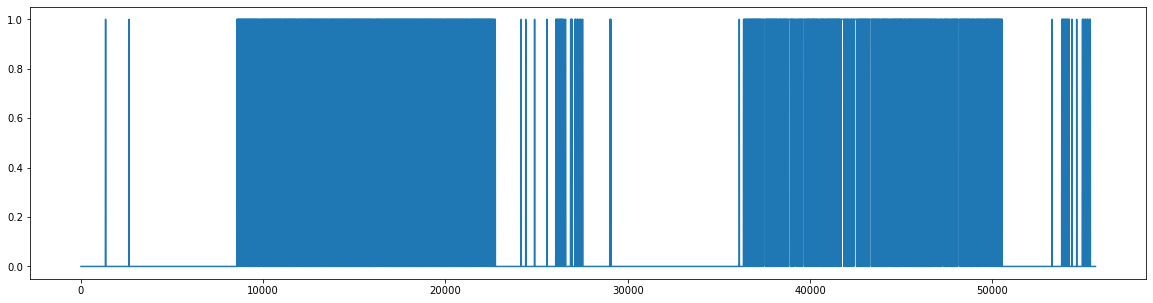

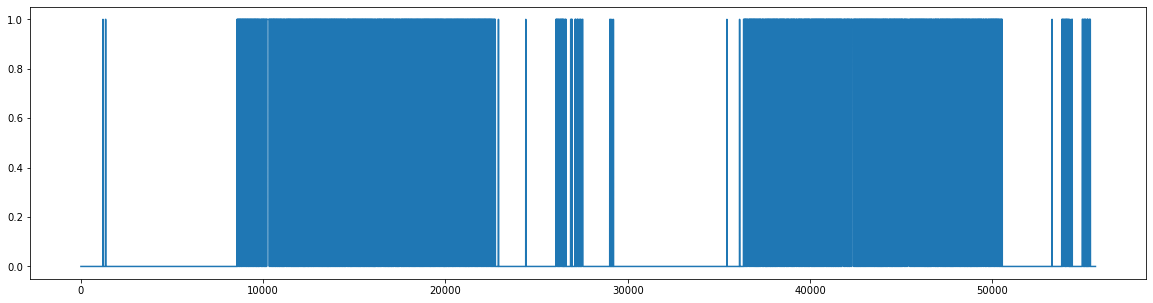

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: fft - WINDOW SIZE: 6
######################################################################
Epoch 1/5
11269/11269 [==============================] - 28s 2ms/step - loss: 0.1009 - accuracy: 0.9601
Epoch 2/5
11269/11269 [==============================] - 28s 2ms/step - loss: 0.0735 - accuracy: 0.9693
Epoch 3/5
11269/11269 [==============================] - 28s 2ms/step - loss: 0.0683 - accuracy: 0.9712
Epoch 4/5
11269/11269 [==============================] - 27s 2ms/step - loss: 0.0656 - accuracy: 0.9725
Epoch 5/5
290/290 [==============================] - 1s 1ms/step - loss: 0.0853 - accuracy: 0.9600
(55662,) (55662,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.08531127870082855, 0.9600086212158203]
Real test data score:  0.9486184470554417


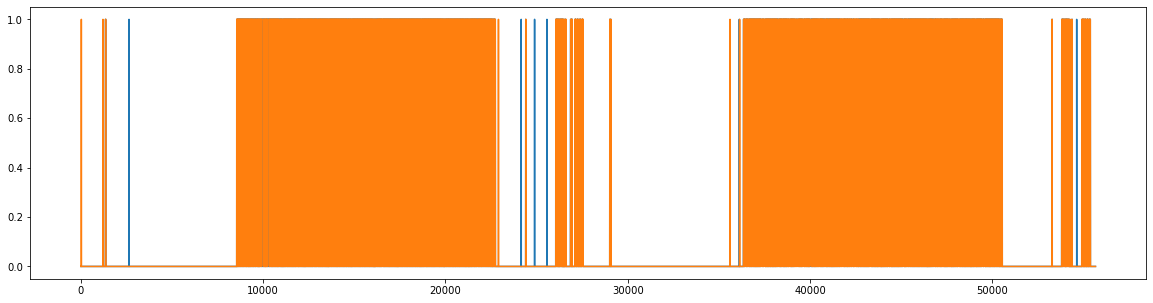

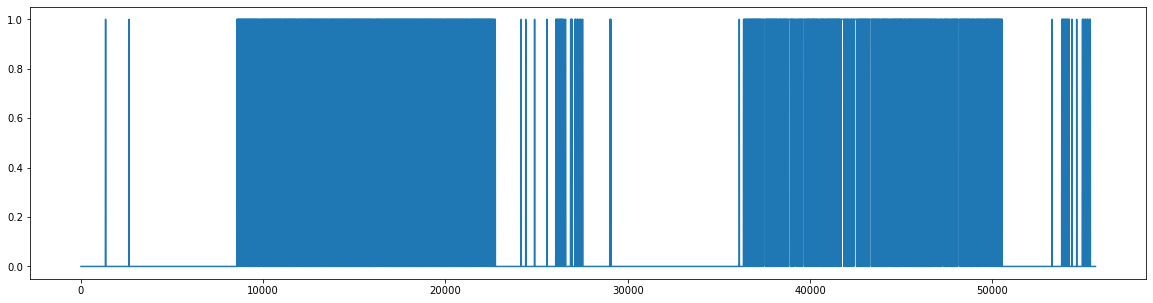

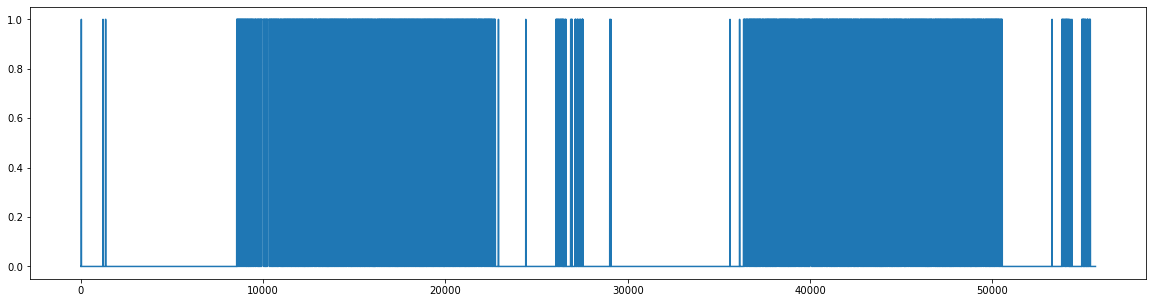

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: None - WINDOW SIZE: 7
######################################################################
Epoch 1/5
9659/9659 [==============================] - 26s 3ms/step - loss: 0.0954 - accuracy: 0.9638
Epoch 2/5
9659/9659 [==============================] - 25s 3ms/step - loss: 0.0554 - accuracy: 0.9781
Epoch 3/5
9659/9659 [==============================] - 25s 3ms/step - loss: 0.0507 - accuracy: 0.9797
Epoch 4/5
9659/9659 [==============================] - 25s 3ms/step - loss: 0.0496 - accuracy: 0.9803
Epoch 5/5
249/249 [==============================] - 1s 1ms/step - loss: 0.0417 - accuracy: 0.9826
(55664,) (55664,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.041655927896499634, 0.9826458692550659]
Real test data score:  0.947722046565105


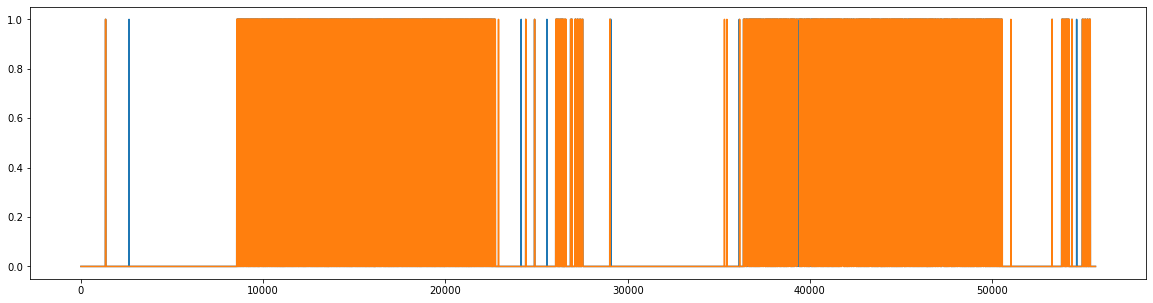

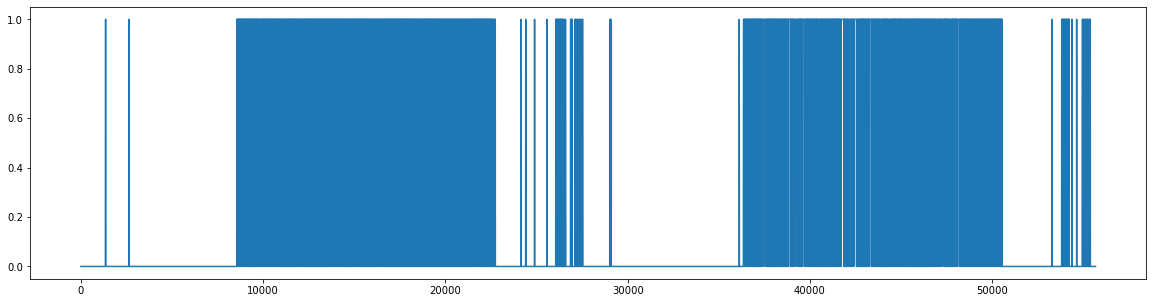

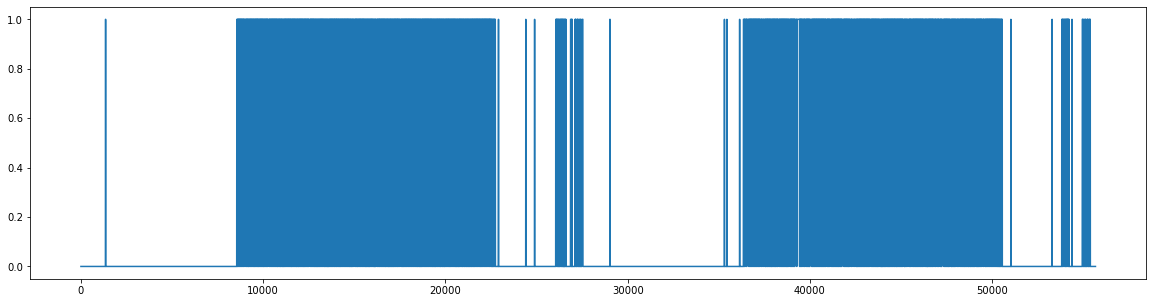

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: dct - WINDOW SIZE: 7
######################################################################
Epoch 1/5
9659/9659 [==============================] - 26s 3ms/step - loss: 0.0954 - accuracy: 0.9640
Epoch 2/5
9659/9659 [==============================] - 26s 3ms/step - loss: 0.0625 - accuracy: 0.9740
Epoch 3/5
9659/9659 [==============================] - 25s 3ms/step - loss: 0.0564 - accuracy: 0.9769
Epoch 4/5
9659/9659 [==============================] - 24s 3ms/step - loss: 0.0540 - accuracy: 0.9774
Epoch 5/5
249/249 [==============================] - 0s 1ms/step - loss: 0.0582 - accuracy: 0.9751
(55664,) (55664,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.058232828974723816, 0.975100576877594]
Real test data score:  0.9445961483184824


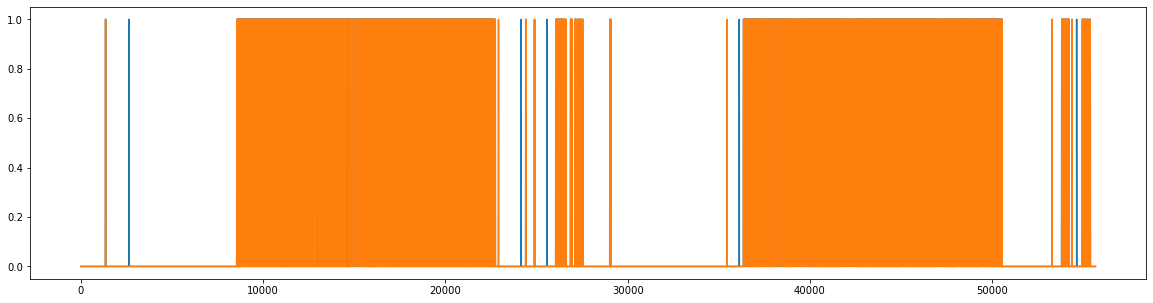

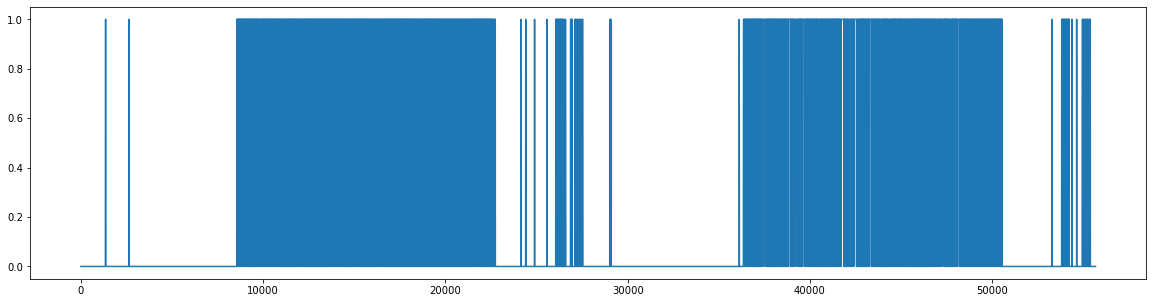

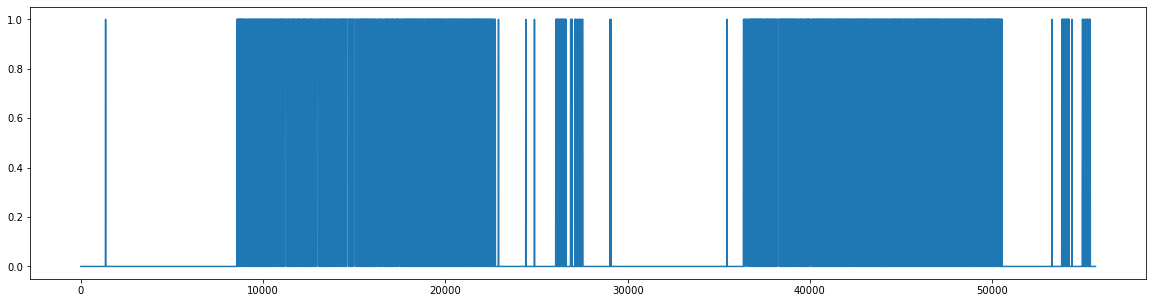

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: fft - WINDOW SIZE: 7
######################################################################
Epoch 1/5
9659/9659 [==============================] - 25s 3ms/step - loss: 0.1004 - accuracy: 0.9615
Epoch 2/5
9659/9659 [==============================] - 26s 3ms/step - loss: 0.0670 - accuracy: 0.9724
Epoch 3/5
9659/9659 [==============================] - 24s 3ms/step - loss: 0.0629 - accuracy: 0.9744
Epoch 4/5
9659/9659 [==============================] - 28s 3ms/step - loss: 0.0618 - accuracy: 0.9744
Epoch 5/5
249/249 [==============================] - 1s 1ms/step - loss: 0.0632 - accuracy: 0.9697
(55664,) (55664,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.06315406411886215, 0.9696931838989258]
Real test data score:  0.9444703937913194


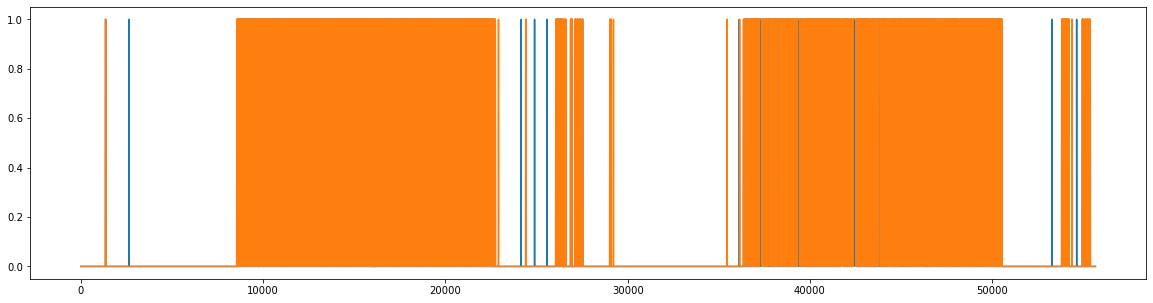

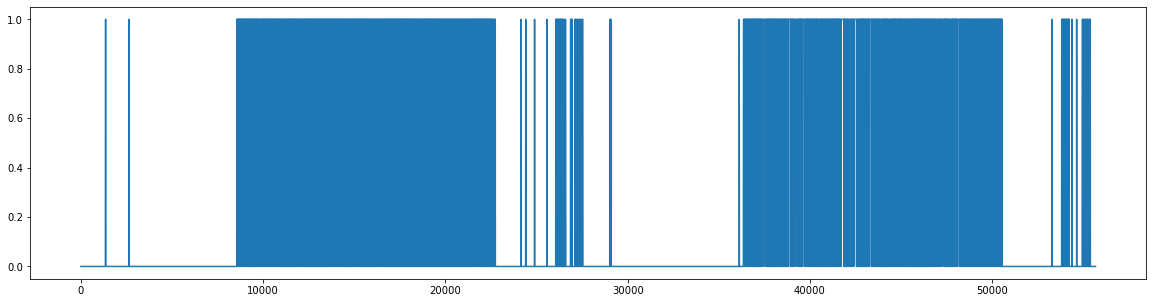

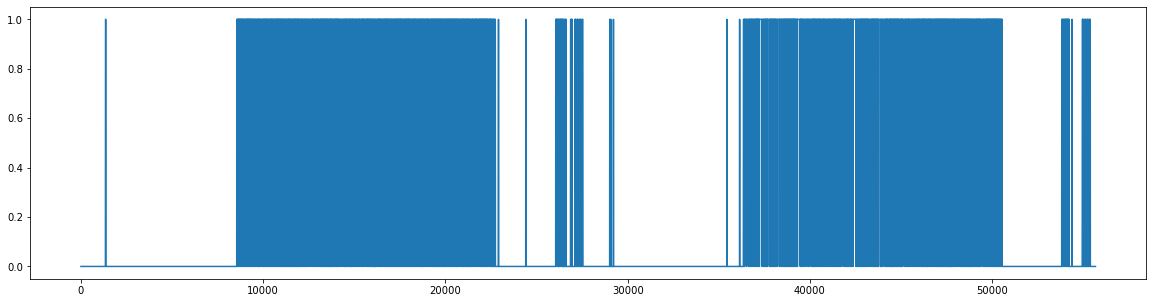

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: None - WINDOW SIZE: 8
######################################################################
Epoch 1/5
8452/8452 [==============================] - 30s 3ms/step - loss: 0.0886 - accuracy: 0.9663
Epoch 2/5
8452/8452 [==============================] - 33s 4ms/step - loss: 0.0548 - accuracy: 0.9781
Epoch 3/5
8452/8452 [==============================] - 31s 4ms/step - loss: 0.0505 - accuracy: 0.9796
Epoch 4/5
8452/8452 [==============================] - 31s 4ms/step - loss: 0.0479 - accuracy: 0.9810
Epoch 5/5
218/218 [==============================] - 1s 2ms/step - loss: 0.0434 - accuracy: 0.9826
(55664,) (55664,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.04341183975338936, 0.9826099276542664]
Real test data score:  0.939961195745904


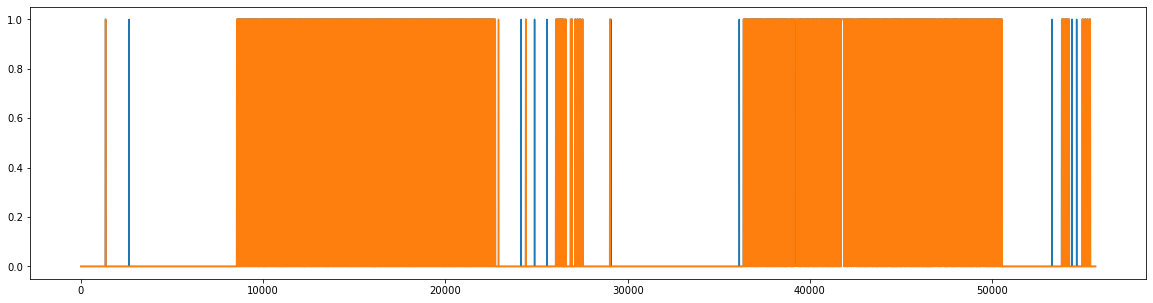

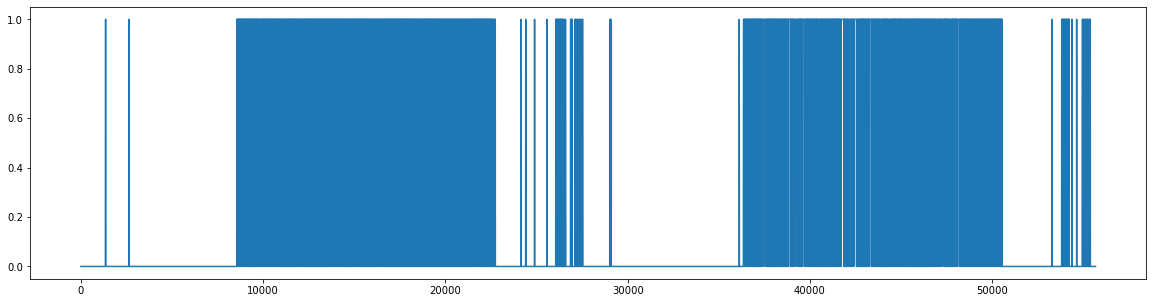

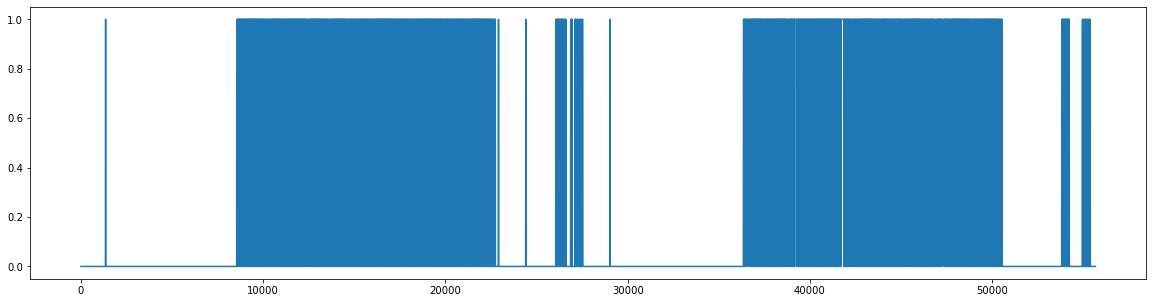

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: dct - WINDOW SIZE: 8
######################################################################
Epoch 1/5
8452/8452 [==============================] - 28s 3ms/step - loss: 0.1040 - accuracy: 0.9596
Epoch 2/5
8452/8452 [==============================] - 28s 3ms/step - loss: 0.0641 - accuracy: 0.9735
Epoch 3/5
8452/8452 [==============================] - 27s 3ms/step - loss: 0.0572 - accuracy: 0.9762
Epoch 4/5
8452/8452 [==============================] - 28s 3ms/step - loss: 0.0548 - accuracy: 0.9776
Epoch 5/5
218/218 [==============================] - 1s 3ms/step - loss: 0.0504 - accuracy: 0.9761
(55664,) (55664,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.050382837653160095, 0.9761425852775574]
Real test data score:  0.9392785283127335


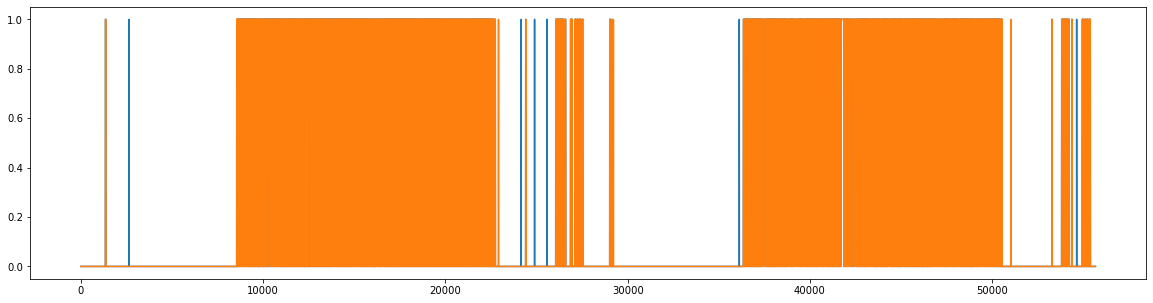

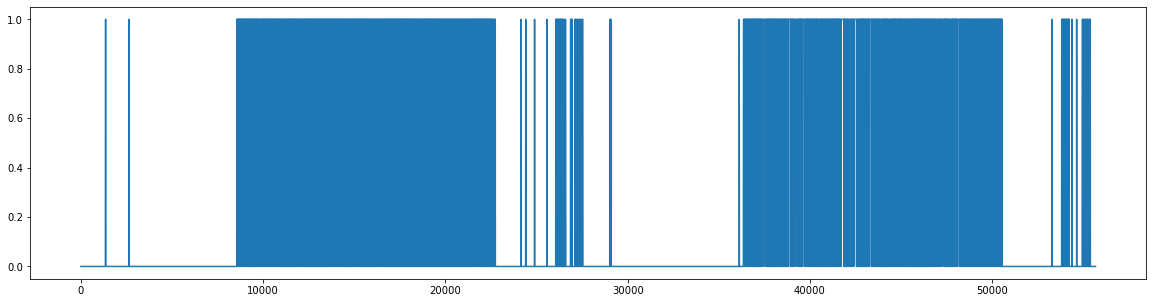

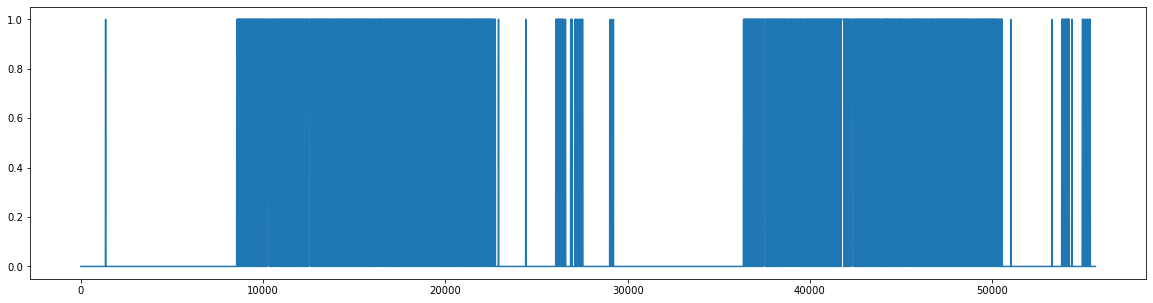

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: fft - WINDOW SIZE: 8
######################################################################
Epoch 1/5
8452/8452 [==============================] - 33s 4ms/step - loss: 0.1050 - accuracy: 0.9588
Epoch 2/5
8452/8452 [==============================] - 29s 3ms/step - loss: 0.0729 - accuracy: 0.9694
Epoch 3/5
8452/8452 [==============================] - 30s 4ms/step - loss: 0.0674 - accuracy: 0.9720
Epoch 4/5
8452/8452 [==============================] - 30s 4ms/step - loss: 0.0672 - accuracy: 0.9724
Epoch 5/5
218/218 [==============================] - 1s 2ms/step - loss: 0.0720 - accuracy: 0.9682
(55664,) (55664,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.07203122228384018, 0.9682379961013794]
Real test data score:  0.9356855418223627


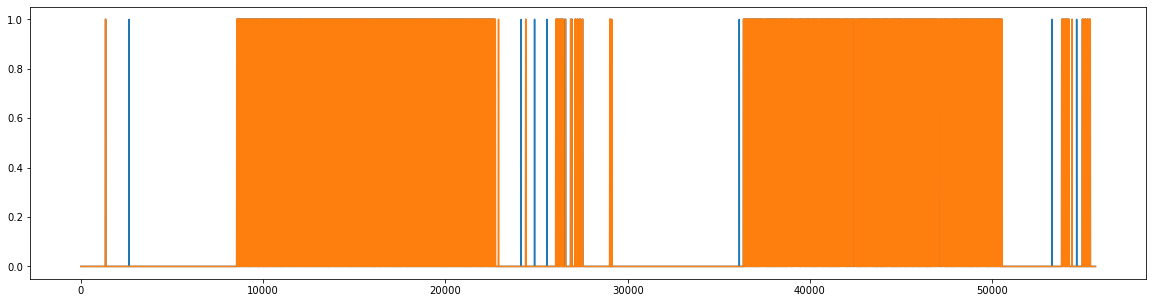

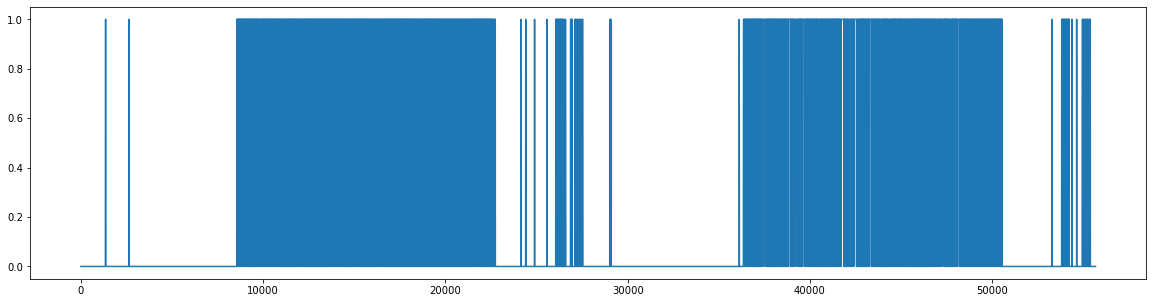

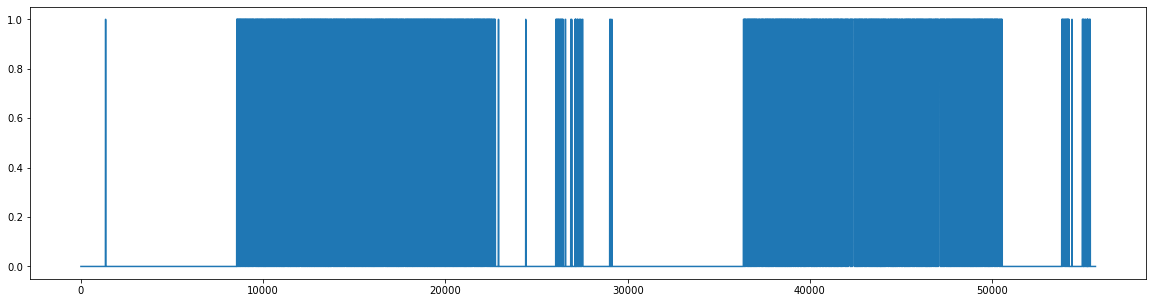

In [25]:
window_size_list = [6, 7, 8]
window_type = 'fixed'
formatted_frames = None
for window_size in window_size_list: 
    skip_size = window_size
    data_formattor = FormatData(DATA_PATH)
    formatted_frames = data_formattor(window_type, window_size=window_size, skip_size=skip_size)
    for transform_type in [None, 'dct', 'fft']:
        print('#'*70)
        print('WINDOW TYPE: {} - TRANSFORM TYPE: {} - WINDOW SIZE: {}'.format(window_type, transform_type, window_size))
        print('#'*70)
        model_trainer = CNNModelTrain(formatted_frames, window_type, transform_type)
        model_trainer()

In [30]:
class CNNModel(tf.keras.Model):
    """
    A class to create the arcitecture of the DNN model

    ...

    Attributes
    ----------
    inputs : array
       the array of inputs that the model would train on
    """

    def __init__(self):
        """
        Initialize the layers of the model
        """
        super(CNNModel, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.act1 = tf.keras.layers.ReLU()

        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.act2 = tf.keras.layers.ReLU()

        self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same")
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.act3 = tf.keras.layers.ReLU()

        self.gap = tf.keras.layers.GlobalAveragePooling2D()
        
        self.flt = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    
    def call(self, inputs):
        """Forwad propagates the inputs into the model

        Parameters
        ----------
        inputs : array
           the array of inputs that the model would train on

        Returns
        -------
        x : tensor
            the output of the model
        """
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = self.conv2(x) 
        x = self.bn2(x)
        x = self.act2(x)
        
        x = self.conv3(x) 
        x = self.bn3(x)
        x = self.act3(x)
        
        x = self.gap(x)
        
        x = self.flt(x)
        x = self.fc1(x)
        return x


######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: None - WINDOW SIZE: 5
######################################################################
Epoch 1/5
13522/13522 [==============================] - 284s 21ms/step - loss: 0.0895 - accuracy: 0.9649
Epoch 2/5
13522/13522 [==============================] - 280s 21ms/step - loss: 0.0617 - accuracy: 0.9750
Epoch 3/5
13522/13522 [==============================] - 243s 18ms/step - loss: 0.0552 - accuracy: 0.9771
Epoch 4/5
13522/13522 [==============================] - 236s 17ms/step - loss: 0.0531 - accuracy: 0.9781
Epoch 5/5
348/348 [==============================] - 2s 6ms/step - loss: 0.0516 - accuracy: 0.9785
(55665,) (55665,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.05155406519770622, 0.9785323143005371]
Real test data score:  0.9576933441120992


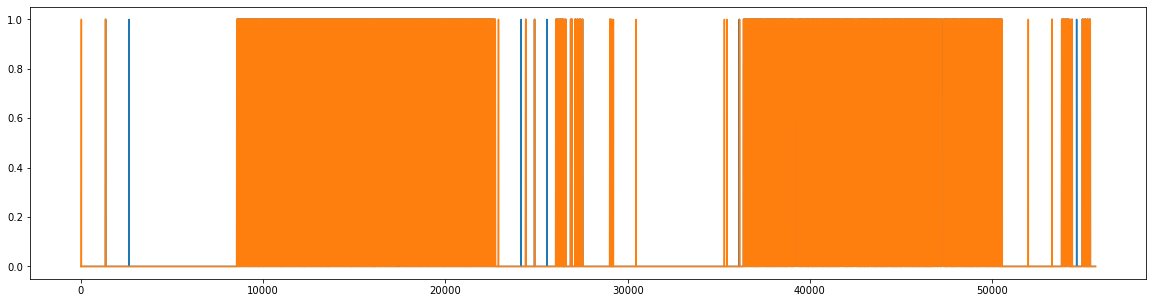

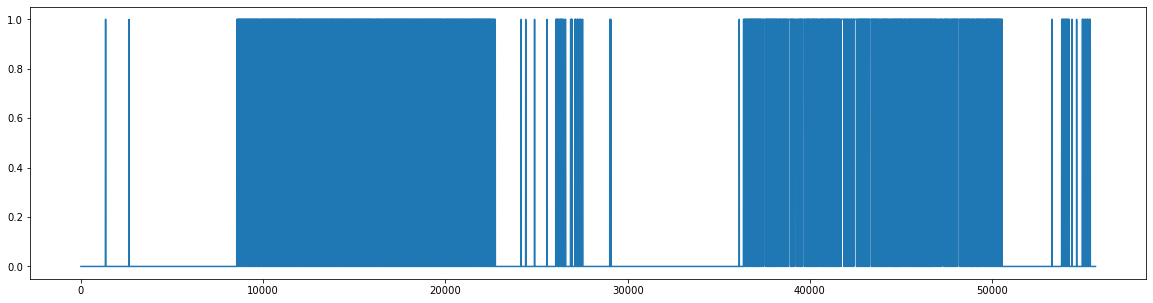

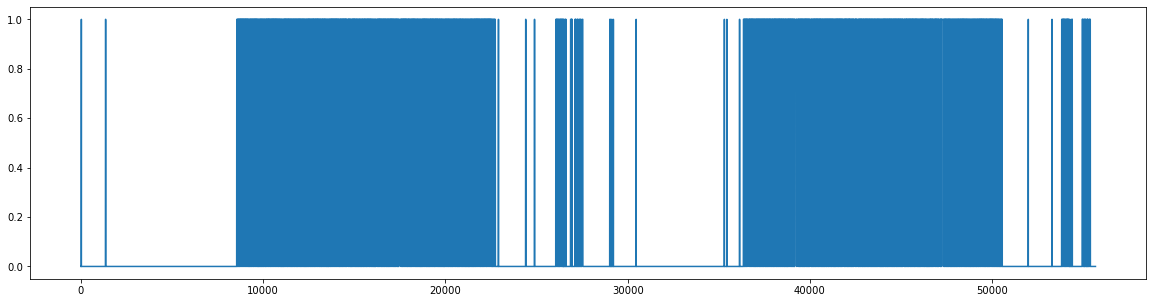

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: dct - WINDOW SIZE: 5
######################################################################
Epoch 1/5
13522/13522 [==============================] - 237s 17ms/step - loss: 0.0967 - accuracy: 0.9615
Epoch 2/5
13522/13522 [==============================] - 233s 17ms/step - loss: 0.0650 - accuracy: 0.9729
Epoch 3/5
13522/13522 [==============================] - 402s 30ms/step - loss: 0.0598 - accuracy: 0.9751
Epoch 4/5
13522/13522 [==============================] - 319s 24ms/step - loss: 0.0567 - accuracy: 0.9762
Epoch 5/5
348/348 [==============================] - 2s 5ms/step - loss: 0.0829 - accuracy: 0.9635
(55665,) (55665,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.08293280750513077, 0.9635318517684937]
Real test data score:  0.953040510194916


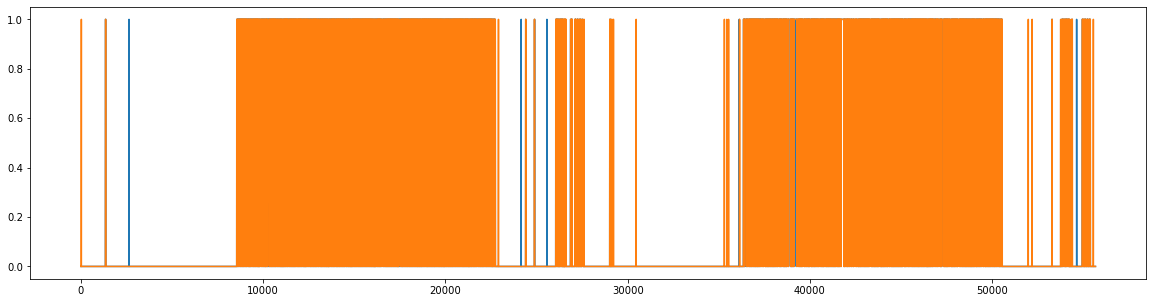

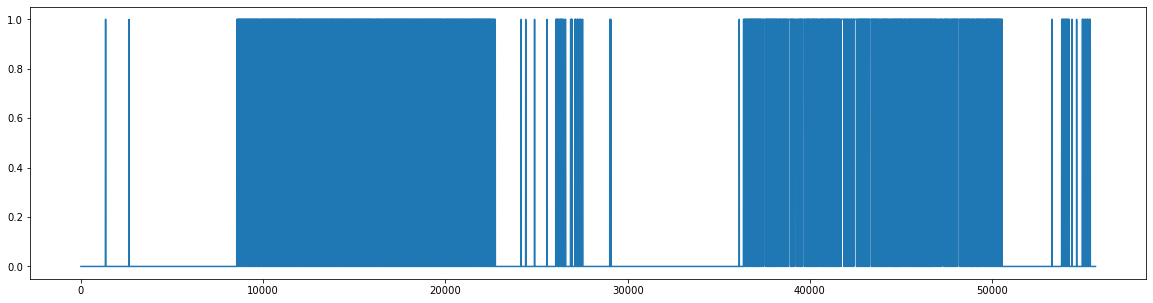

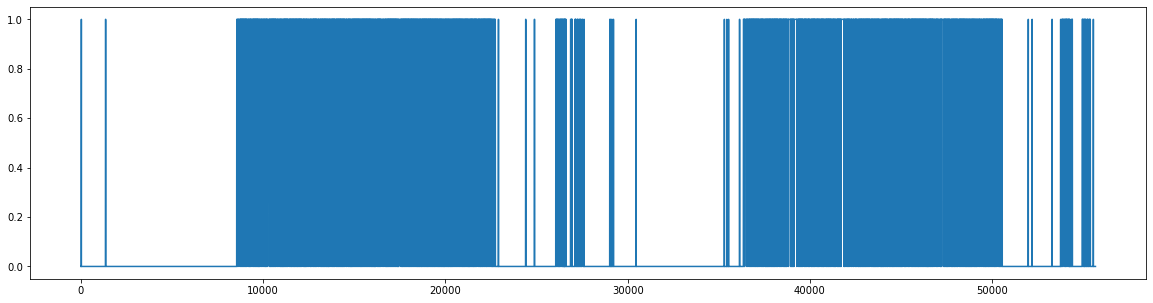

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: fft - WINDOW SIZE: 5
######################################################################
Epoch 1/5
13522/13522 [==============================] - 232s 17ms/step - loss: 0.1007 - accuracy: 0.9598
Epoch 2/5
13522/13522 [==============================] - 232s 17ms/step - loss: 0.0677 - accuracy: 0.9719
Epoch 3/5
13522/13522 [==============================] - 232s 17ms/step - loss: 0.0636 - accuracy: 0.9732
Epoch 4/5
13522/13522 [==============================] - 231s 17ms/step - loss: 0.0619 - accuracy: 0.9740
Epoch 5/5
348/348 [==============================] - 2s 5ms/step - loss: 0.0845 - accuracy: 0.9620
(55665,) (55665,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.08448673784732819, 0.9620048403739929]
Real test data score:  0.9522680319770053


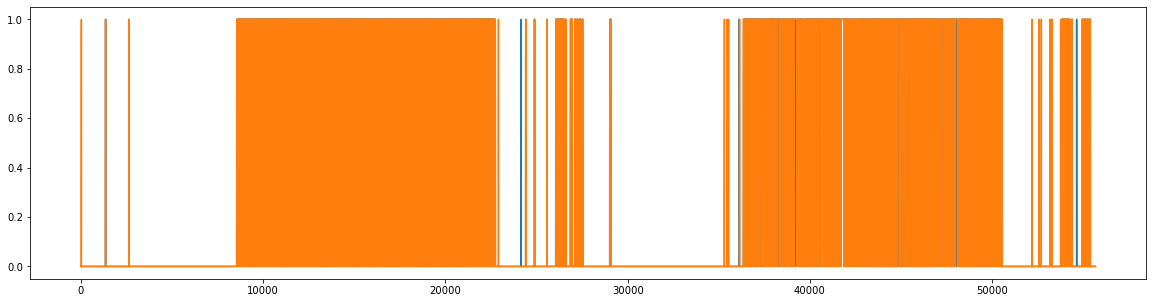

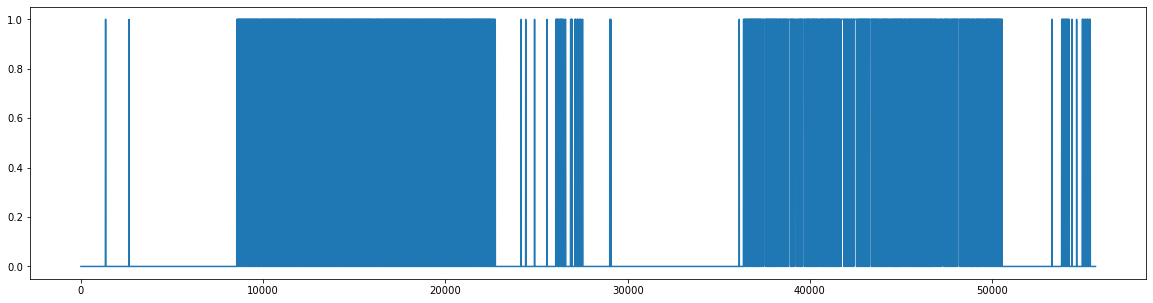

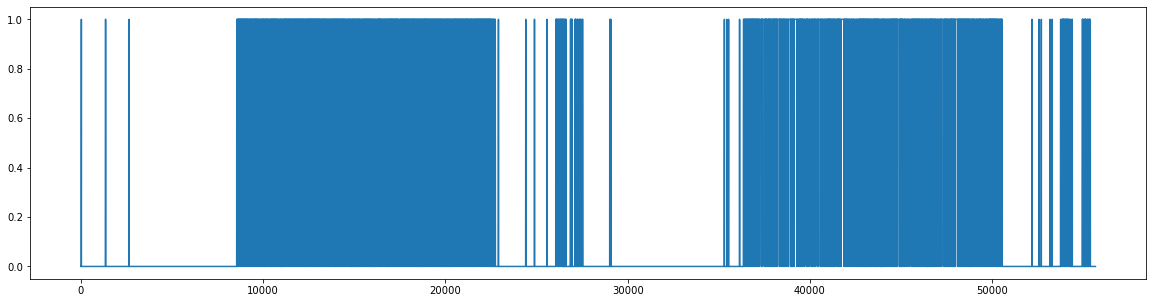

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: None - WINDOW SIZE: 6
######################################################################
Epoch 1/5
11269/11269 [==============================] - 260s 23ms/step - loss: 0.0964 - accuracy: 0.9611
Epoch 2/5
11269/11269 [==============================] - 261s 23ms/step - loss: 0.0624 - accuracy: 0.9742
Epoch 3/5
11269/11269 [==============================] - 253s 22ms/step - loss: 0.0565 - accuracy: 0.9766
Epoch 4/5
11269/11269 [==============================] - 247s 22ms/step - loss: 0.0539 - accuracy: 0.9777
Epoch 5/5
290/290 [==============================] - 5s 6ms/step - loss: 0.0420 - accuracy: 0.9828
(55662,) (55662,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.042040929198265076, 0.9827530384063721]
Real test data score:  0.9523552872695915


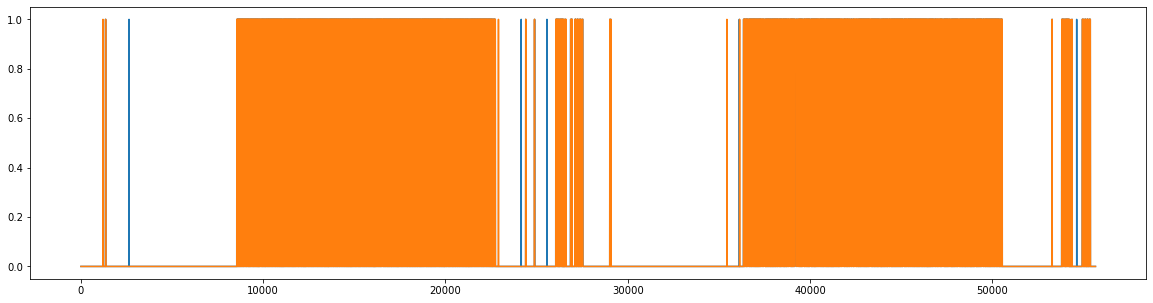

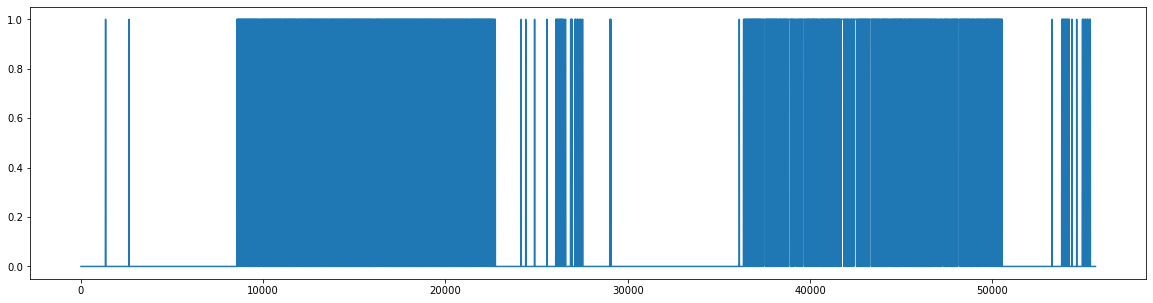

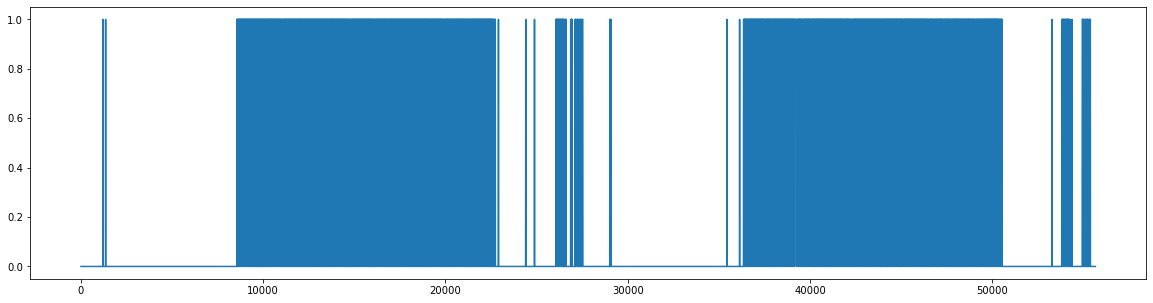

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: dct - WINDOW SIZE: 6
######################################################################
Epoch 1/5
11269/11269 [==============================] - 348s 31ms/step - loss: 0.1001 - accuracy: 0.9602s - loss: 0.1001 - accu
Epoch 2/5
11269/11269 [==============================] - 375s 33ms/step - loss: 0.0706 - accuracy: 0.9706
Epoch 3/5
11269/11269 [==============================] - 316s 28ms/step - loss: 0.0629 - accuracy: 0.9736
Epoch 4/5
11269/11269 [==============================] - 229s 20ms/step - loss: 0.0587 - accuracy: 0.9756
Epoch 5/5
290/290 [==============================] - 3s 6ms/step - loss: 0.0523 - accuracy: 0.9781
(55662,) (55662,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.052323680371046066, 0.9781179428100586]
Real test data score:  0.94

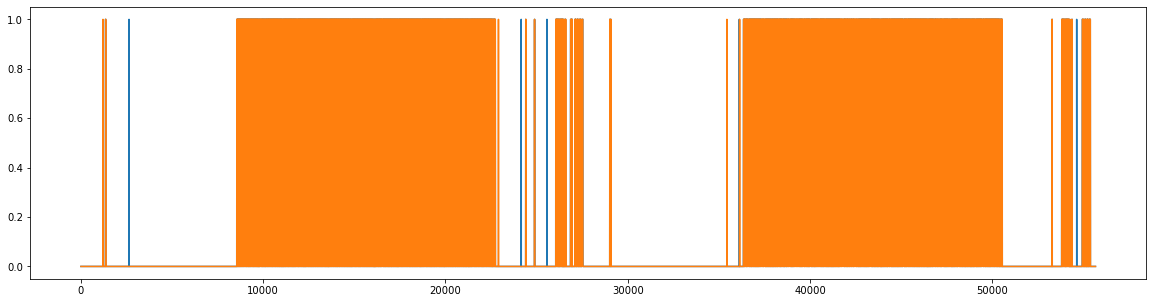

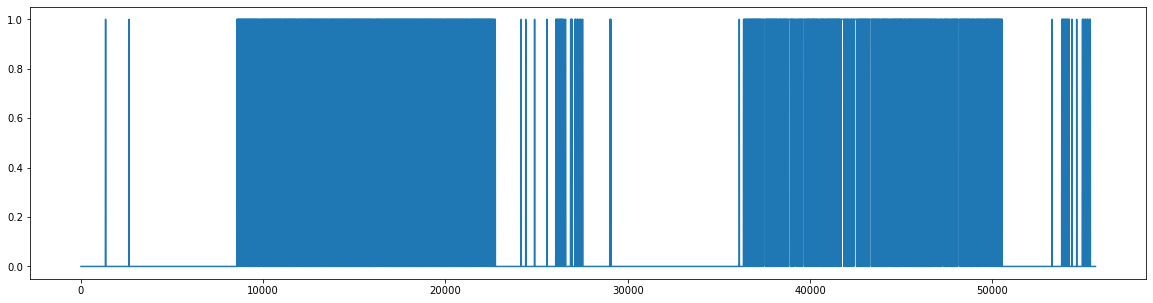

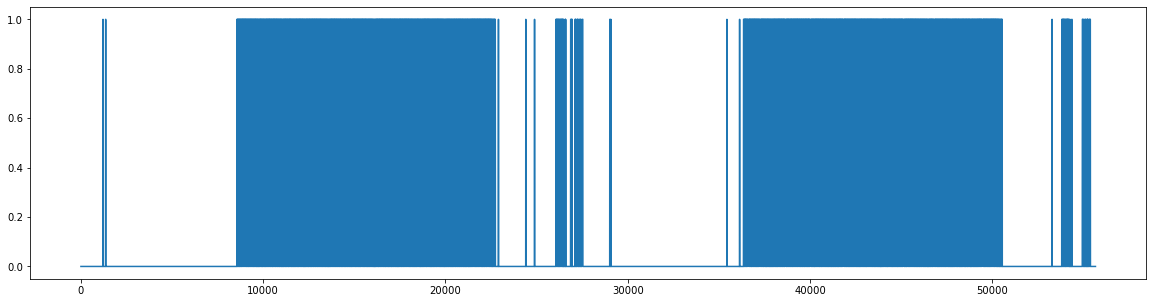

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: fft - WINDOW SIZE: 6
######################################################################
Epoch 1/5
11269/11269 [==============================] - 303s 26ms/step - loss: 0.1060 - accuracy: 0.9570
Epoch 2/5
11269/11269 [==============================] - 265s 23ms/step - loss: 0.0746 - accuracy: 0.9683
Epoch 3/5
11269/11269 [==============================] - 249s 22ms/step - loss: 0.0696 - accuracy: 0.9705
Epoch 4/5
11269/11269 [==============================] - 243s 22ms/step - loss: 0.0675 - accuracy: 0.9711
Epoch 5/5
290/290 [==============================] - 2s 7ms/step - loss: 0.0766 - accuracy: 0.9669
(55662,) (55662,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.07664542645215988, 0.9669073820114136]
Real test data score:  0.9478998239373361


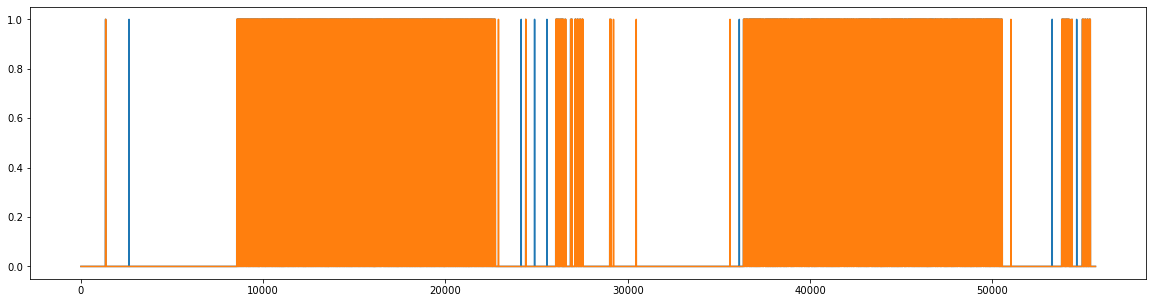

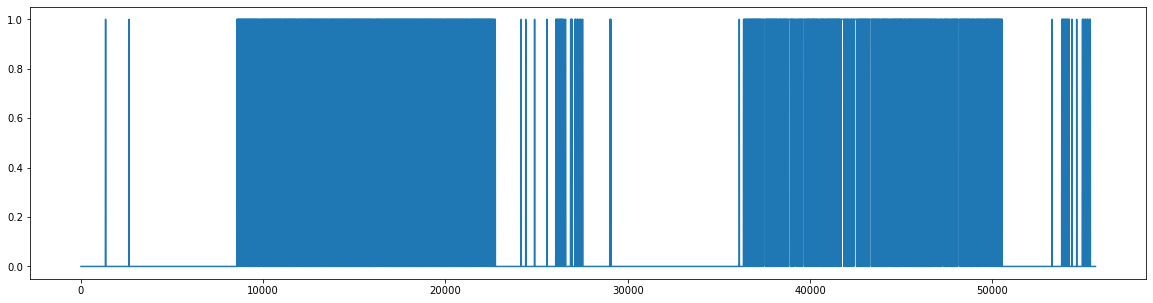

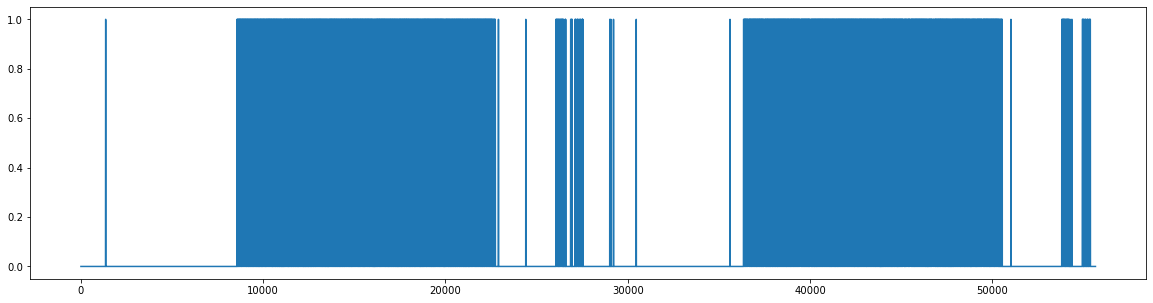

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: None - WINDOW SIZE: 7
######################################################################
Epoch 1/5
9659/9659 [==============================] - 261s 27ms/step - loss: 0.0906 - accuracy: 0.9636
Epoch 2/5
9659/9659 [==============================] - 245s 25ms/step - loss: 0.0598 - accuracy: 0.9753
Epoch 3/5
9659/9659 [==============================] - 233s 24ms/step - loss: 0.0556 - accuracy: 0.9771
Epoch 4/5
9659/9659 [==============================] - 235s 24ms/step - loss: 0.0513 - accuracy: 0.9789
Epoch 5/5
249/249 [==============================] - 2s 7ms/step - loss: 0.0504 - accuracy: 0.9766
(55664,) (55664,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.05038359761238098, 0.9766096472740173]
Real test data score:  0.9456021845357861


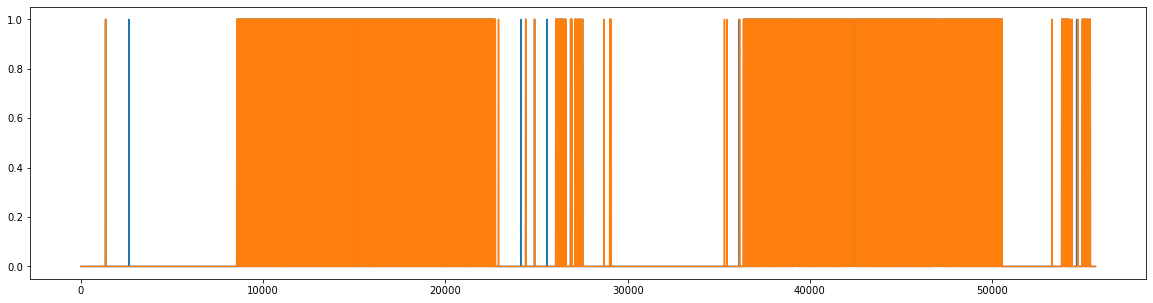

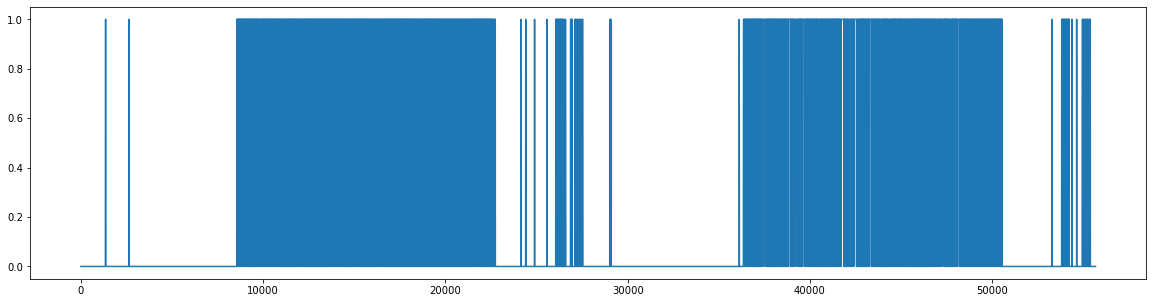

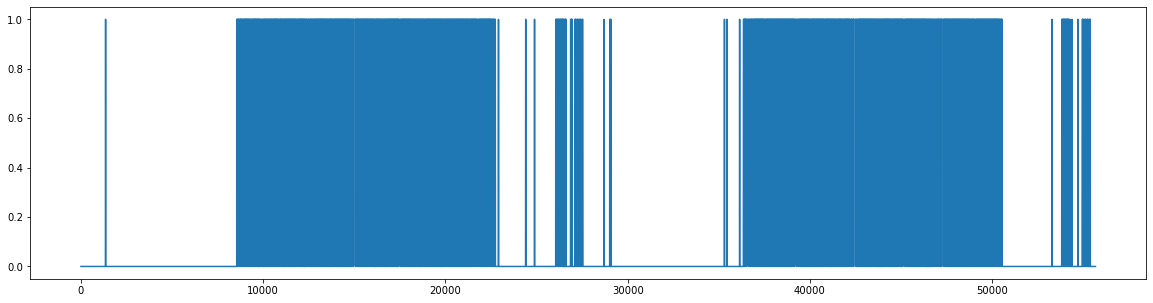

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: dct - WINDOW SIZE: 7
######################################################################
Epoch 1/5
9659/9659 [==============================] - 245s 25ms/step - loss: 0.0976 - accuracy: 0.9617
Epoch 2/5
9659/9659 [==============================] - 242s 25ms/step - loss: 0.0673 - accuracy: 0.9720
Epoch 3/5
9659/9659 [==============================] - 244s 25ms/step - loss: 0.0614 - accuracy: 0.9746
Epoch 4/5
9659/9659 [==============================] - 245s 25ms/step - loss: 0.0587 - accuracy: 0.9754
Epoch 5/5
249/249 [==============================] - 2s 7ms/step - loss: 0.0626 - accuracy: 0.9716
(55664,) (55664,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.06260617822408676, 0.9715794920921326]
Real test data score:  0.9460333429146306


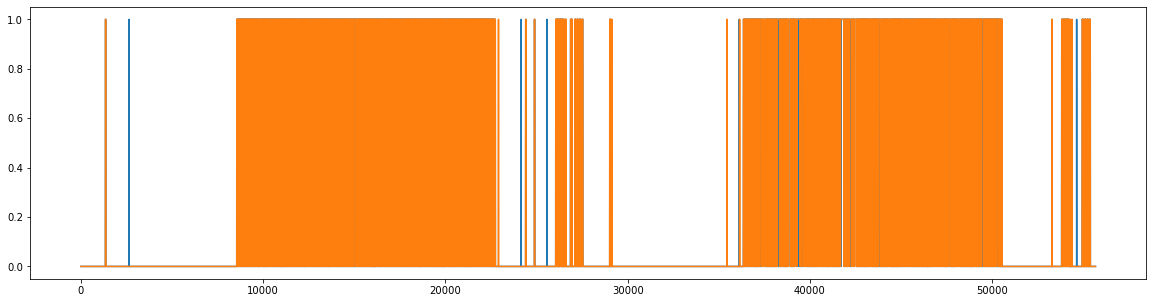

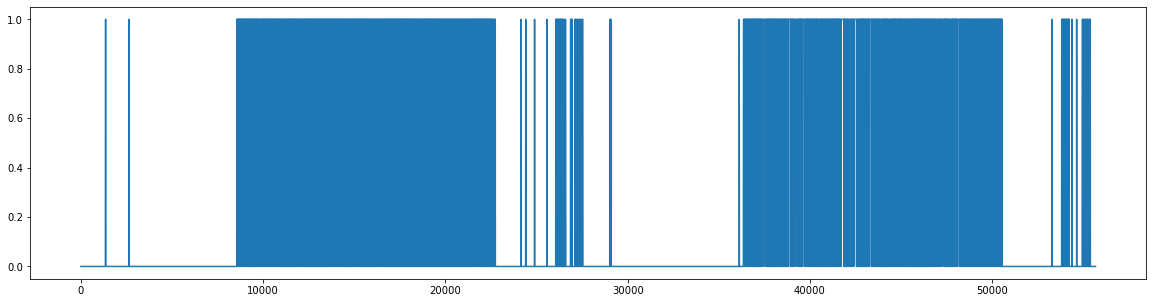

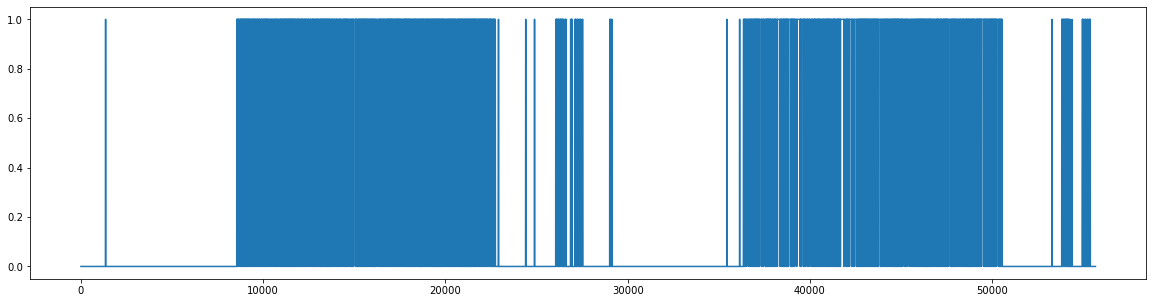

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: fft - WINDOW SIZE: 7
######################################################################
Epoch 1/5
9659/9659 [==============================] - 231s 24ms/step - loss: 0.1028 - accuracy: 0.9586
Epoch 2/5
9659/9659 [==============================] - 231s 24ms/step - loss: 0.0699 - accuracy: 0.9712
Epoch 3/5
9659/9659 [==============================] - 230s 24ms/step - loss: 0.0662 - accuracy: 0.9722
Epoch 4/5
9659/9659 [==============================] - 229s 24ms/step - loss: 0.0627 - accuracy: 0.9737s - loss: 0.0627 - 
Epoch 5/5
249/249 [==============================] - 2s 7ms/step - loss: 0.0687 - accuracy: 0.9682
(55664,) (55664,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.0687158927321434, 0.9681841135025024]
Real test data score:  0.9445422535211268

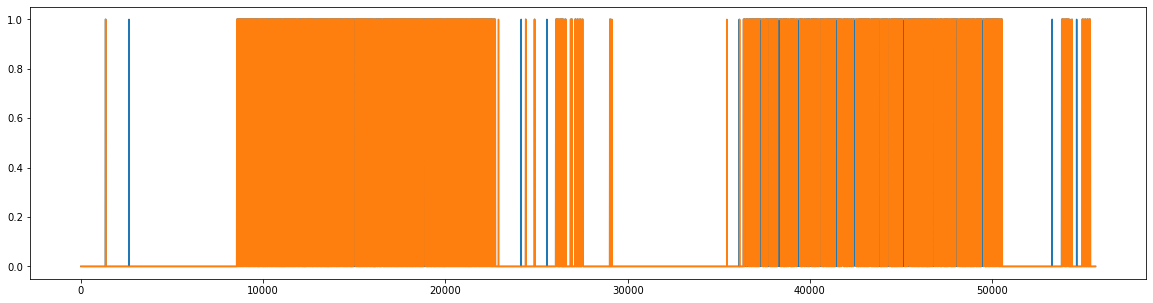

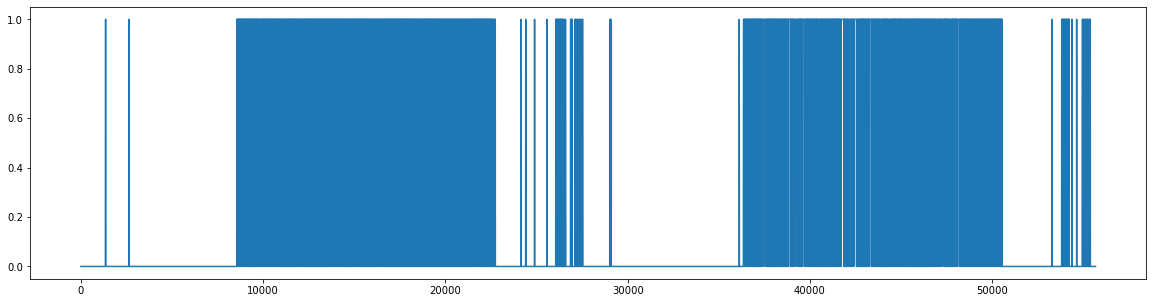

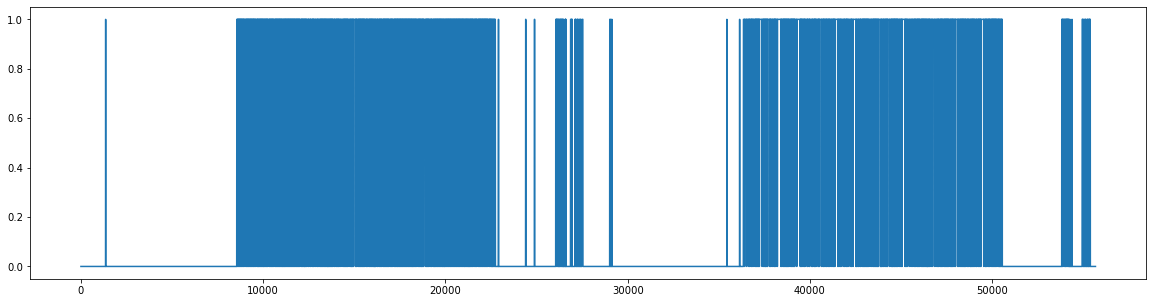

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: None - WINDOW SIZE: 8
######################################################################
Epoch 1/5
8452/8452 [==============================] - 219s 26ms/step - loss: 0.0979 - accuracy: 0.9604
Epoch 2/5
8452/8452 [==============================] - 208s 25ms/step - loss: 0.0626 - accuracy: 0.9737
Epoch 3/5
8452/8452 [==============================] - 199s 24ms/step - loss: 0.0546 - accuracy: 0.9774
Epoch 4/5
8452/8452 [==============================] - 199s 24ms/step - loss: 0.0508 - accuracy: 0.9791
Epoch 5/5
218/218 [==============================] - 2s 5ms/step - loss: 0.0583 - accuracy: 0.9708
(55664,) (55664,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.058273863047361374, 0.9708249568939209]
Real test data score:  0.9426559356136821


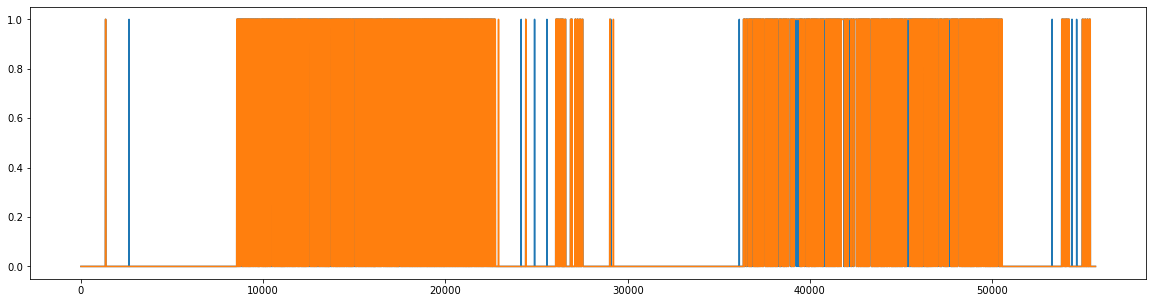

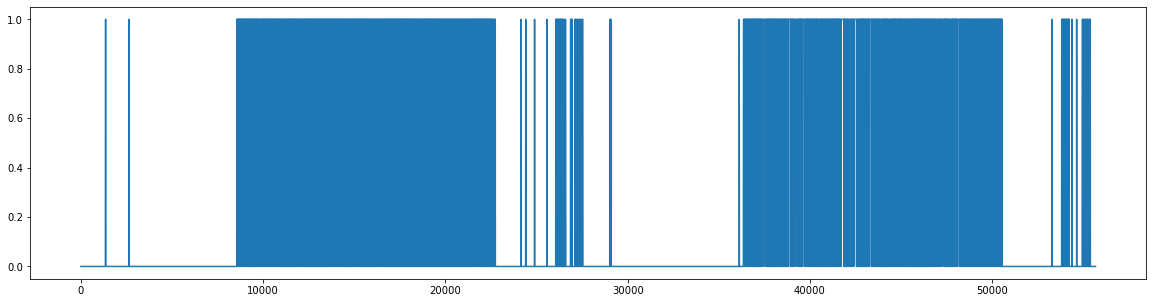

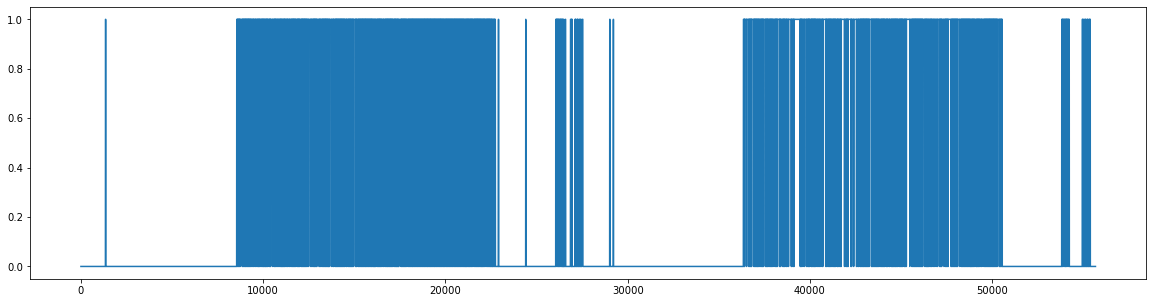

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: dct - WINDOW SIZE: 8
######################################################################
Epoch 1/5
8452/8452 [==============================] - 191s 22ms/step - loss: 0.1056 - accuracy: 0.9575
Epoch 2/5
8452/8452 [==============================] - 190s 23ms/step - loss: 0.0707 - accuracy: 0.9705
Epoch 3/5
8452/8452 [==============================] - 191s 23ms/step - loss: 0.0634 - accuracy: 0.9731
Epoch 4/5
8452/8452 [==============================] - 190s 22ms/step - loss: 0.0591 - accuracy: 0.9746
Epoch 5/5
218/218 [==============================] - 1s 5ms/step - loss: 0.0601 - accuracy: 0.9741
(55664,) (55664,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.06014452874660492, 0.9741305112838745]
Real test data score:  0.9399971256108077


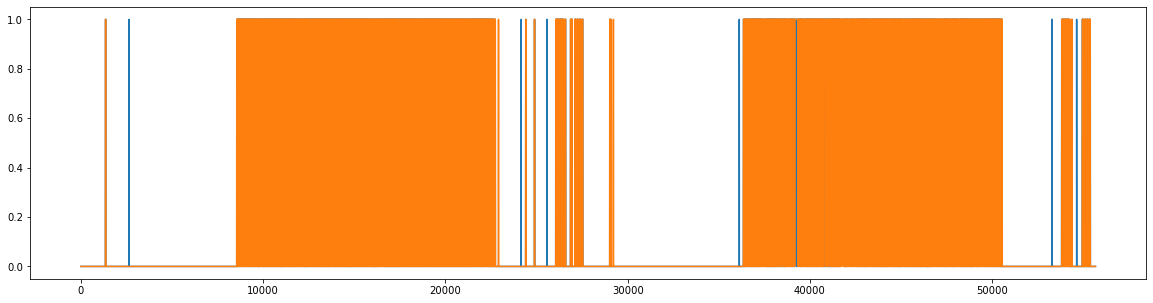

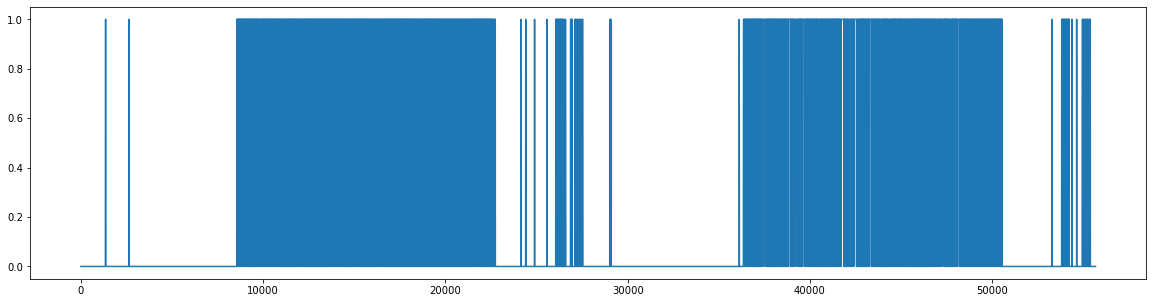

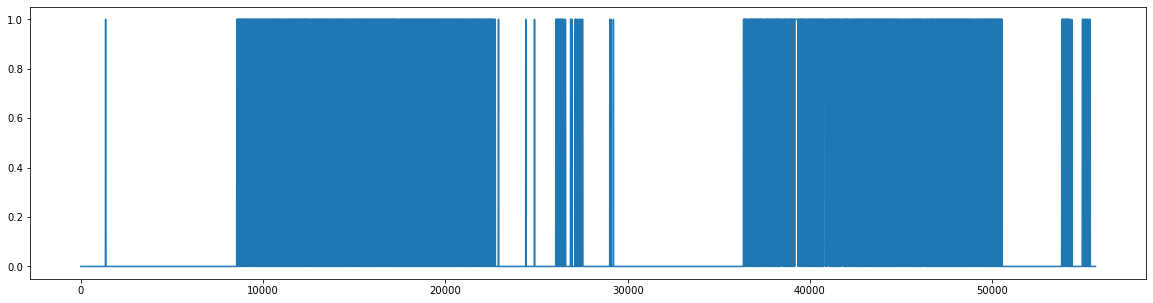

######################################################################
WINDOW TYPE: fixed - TRANSFORM TYPE: fft - WINDOW SIZE: 8
######################################################################
Epoch 1/5
8452/8452 [==============================] - 200s 23ms/step - loss: 0.1238 - accuracy: 0.9504
Epoch 2/5
8452/8452 [==============================] - 198s 23ms/step - loss: 0.0754 - accuracy: 0.9684
Epoch 3/5
8452/8452 [==============================] - 198s 23ms/step - loss: 0.0714 - accuracy: 0.9698
Epoch 4/5
8452/8452 [==============================] - 199s 24ms/step - loss: 0.0681 - accuracy: 0.9712
Epoch 5/5
218/218 [==============================] - 1s 5ms/step - loss: 0.0665 - accuracy: 0.9728
(55664,) (55664,)

        ##################################
        #            DNN model           #
        ##################################
        
Windowed test data score:  [0.06654788553714752, 0.9728370308876038]
Real test data score:  0.9350747341189997


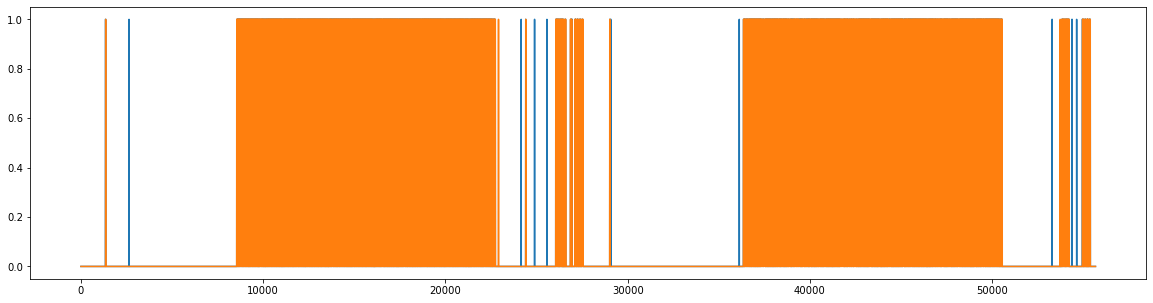

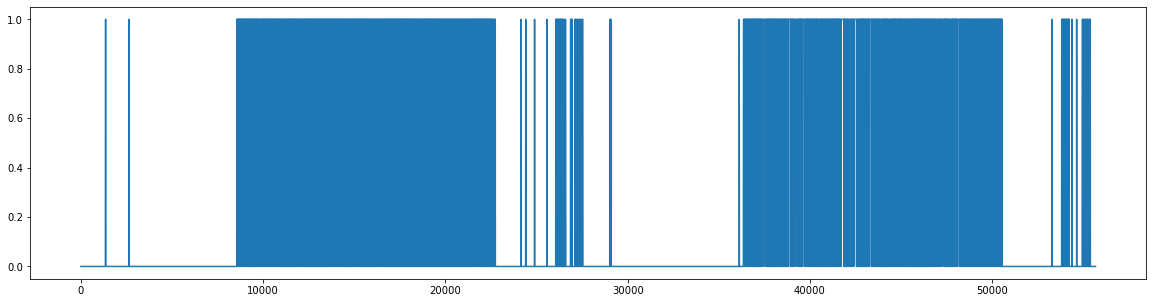

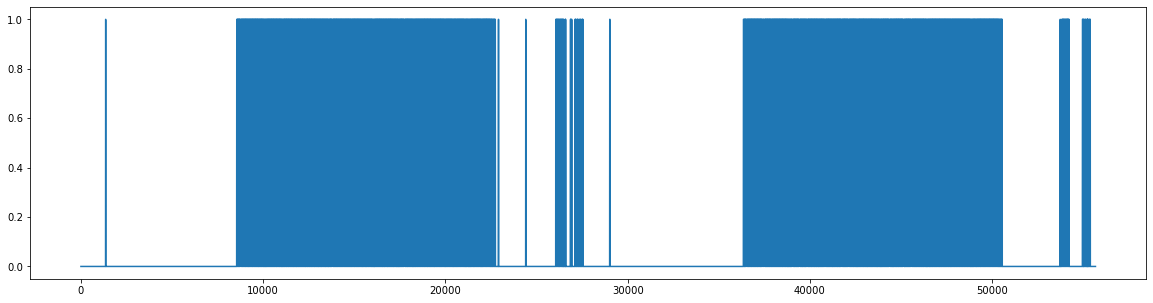

In [31]:
window_size_list = [5, 6, 7, 8]
window_type = 'fixed'
formatted_frames = None
for window_size in window_size_list: 
    skip_size = window_size
    data_formattor = FormatData(DATA_PATH)
    formatted_frames = data_formattor(window_type, window_size=window_size, skip_size=skip_size)
    for transform_type in [None, 'dct', 'fft']:
        print('#'*70)
        print('WINDOW TYPE: {} - TRANSFORM TYPE: {} - WINDOW SIZE: {}'.format(window_type, transform_type, window_size))
        print('#'*70)
        model_trainer = CNNModelTrain(formatted_frames, window_type, transform_type)
        model_trainer()

**TODOs: Overlaping windows**